<a href="https://colab.research.google.com/github/ananyaaa-j/QCES/blob/main/Project3_tsunami.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3: Tsunami
In this project, we will use Dedalus to model the propagation of Tsunami waves. Tsunami typically have wavelengths larger than 100km and periods of about 1 hour. Since their wavelength is much larger than the depth of the ocean, Tsunami can be modelled using the shallow water equations.

Here, we will use Dedalus to solve an initial value problem for the shallow water equations. We will generate a Tsunami using a localized disturbance to the water height.

Student tasks are in [Section 1.3]( #section1pt3 ), [Section 2.3]( #section2pt3 ), and [Section 3.3]( #section3pt3 ).

## Setup
If you are using Google colab, run the script below to install Dedalus

In [1]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus not installed yet.
Installing for Google Colab.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
Suggested packages:
  libfftw3-doc
The following NEW packages will be installed:
  libfftw3-bin libfftw3-dev libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
0 upgraded, 6 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,654 kB of archives.
After this operation, 24.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-double3 amd64 3.3.8-2ubuntu8 [770 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-long3 amd64 3.3.8-2ubuntu8 [335 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-quad3 amd64 3.3.8-2ubuntu8 [614 kB]
Get:4 http://archiv

## 1.  1D shallow water equations
Let's start by solving the shallow water equations in 1D with periodic boundary conditions in our spatial variable, $x$. The script below solves the following equations:

$$ \partial_t u + g \partial_x(h) = - u\partial_x u$$
$$ \partial_t h + \partial_x(Hu) = -\partial_x(hu)$$

In these equations, $g$ is the constant gravitational acceleration, $u$ is the velocity in the $x$ direction, $H$ is the resting height, and $h$ is the height of the free surface relative to $H$. Note that the terms on the right hand side are nonlinear in our dependent variables, and we will use an explicit timestepping method for these terms. Recall that Dedalus uses explicit timestepping for terms on the right hand side of the inputted equation.

Because we are interested in an application to Tsunami, we will solve the equations using dimensional variables. It is convenient to define simulation units at the start of the script so that we can be explicit about the units.

We will start with the following initial conditions:
$$ h=e^{-(x-x_1)^2/w_1^2} $$
$$ u=0 $$
where $x_1$ is the center and $w_1=100$ km is the width of the Gaussian perturbation.

To see how the waves change as they approach shallow water, we will set the resting water depth to include a localized seamount using the form:
$$ H=H_0-(H_0-H_{min})e^{(-(x-x_2)^2/w_2^2)} $$
where $x_2$ is the location of the seamount, $H_0=4$ km is the depth of the ocean away from the seamount, and $H_{min}$ is the minimum water depth above the seamount. Note that since $H\ll w$, the shallow water approximation is appropriate here.

### 1.1  Dedalus script to solve the 1D shallow water equations

The script below solves the 1D shallow water equations with the initial conditions given above.

In [128]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size
Nx = 512 # The number of gridpoints in x
g = 9.81 * meter / second**2 # Gravitational acceleration
H0 = 4 * kilometer # Reference ocean depth
w1 = 20 * kilometer # Width of the initial perturbation
x1 = 200 * kilometer # Center of the initial perturbation
x2 = 500 * kilometer # Center of the seamount
w2 = 100 * kilometer # Width of the seamount
H_min = 100 * meter # minimum depth above the seamount

timestep = 60 * second # Specify the timestep
stop_sim_time = 100 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Create an x-coordinate, a corresponding basis, and a distributor
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(0, Lx))
x = dist.local_grid(x_basis)

# Specify the Fields and set the initial conditions
u = dist.Field(name='u', bases=x_basis)
h = dist.Field(name='h', bases=x_basis)
H = dist.Field(name='H', bases=x_basis)
h.change_scales(1)
H.change_scales(1)
u.change_scales(1)
H['g'] = H0-(H0-H_min)*np.exp(-(x-x2)**2.0/w2**2.0)
h['g'] = np.exp(-(x-x1)**2.0/w1**2.0)  # Initialize the height with a Gaussian function with width set above
u['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord)

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u)")
problem.add_equation("dt(h) + dx(H*u) = - dx(h*u)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.8e+01/s


2024-12-19 17:42:42,348 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.8e+01/s


INFO:__main__:Starting main loop


2024-12-19 17:42:42,355 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-12-19 17:42:42,548 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 100


2024-12-19 17:42:42,552 solvers 0/1 INFO :: Final iteration: 100


INFO:solvers:Final sim time: 6000.0


2024-12-19 17:42:42,555 solvers 0/1 INFO :: Final sim time: 6000.0


INFO:solvers:Setup time (init - iter 0): 0.06992 sec


2024-12-19 17:42:42,558 solvers 0/1 INFO :: Setup time (init - iter 0): 0.06992 sec


INFO:solvers:Warmup time (iter 0-10): 0.03936 sec


2024-12-19 17:42:42,560 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.03936 sec


INFO:solvers:Run time (iter 10-end): 0.1531 sec


2024-12-19 17:42:42,562 solvers 0/1 INFO :: Run time (iter 10-end): 0.1531 sec


INFO:solvers:CPU time (iter 10-end): 4.253e-05 cpu-hr


2024-12-19 17:42:42,564 solvers 0/1 INFO :: CPU time (iter 10-end): 4.253e-05 cpu-hr


INFO:solvers:Speed: 1.202e+06 mode-stages/cpu-sec


2024-12-19 17:42:42,566 solvers 0/1 INFO :: Speed: 1.202e+06 mode-stages/cpu-sec


### 1.2  Plotting
The code below will make a movie of the height.

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-12-19 17:42:45,034 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp5mc46xk7/temp.m4v


2024-12-19 17:42:45,045 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp5mc46xk7/temp.m4v


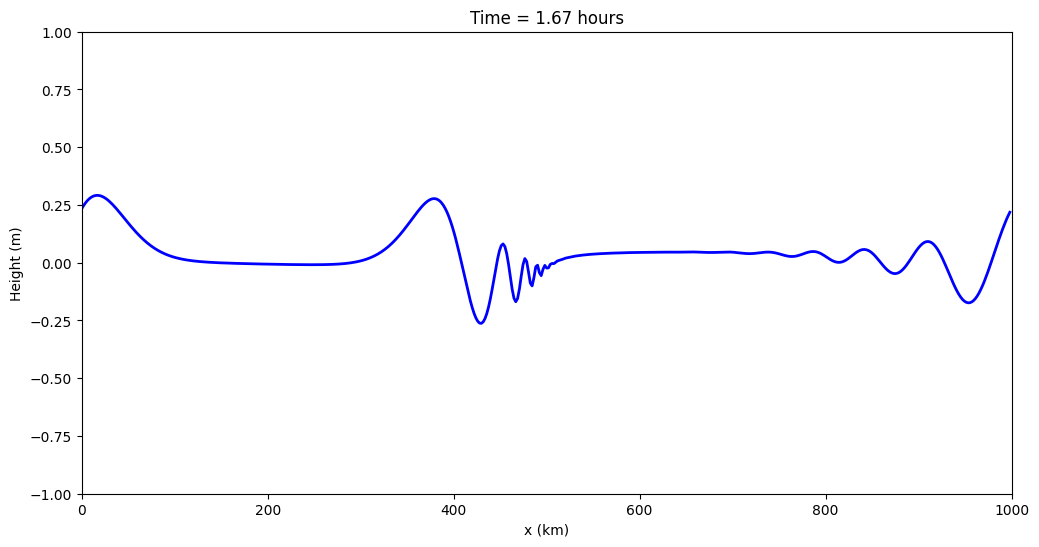

In [129]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Specify the axis limits and labels
plt.xlim((0, Lx / (1*kilometer)))
plt.ylim((-1, 1))
plt.xlabel('x (km)')
plt.ylabel('Height (m)')

# Create objects that will change during the animation
txt_title = plt.title('')
height, = plt.plot([], [], 'b', lw=2)

# Define an animation function
def drawframe(n):
    height.set_data(x/(1*kilometer), h_save[n,:])
    txt_title.set_text('Time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())


### 1.3 Student investigation
<a id='section1pt3'></a>
In the cells below, provide an expression for the expected wave speed and state any assumptions that are necessary to arrive at this. Then plot the wave speed from the output above and compare this with the expected value.

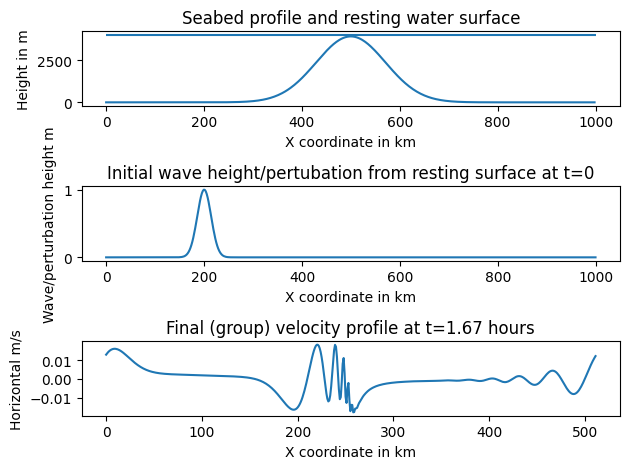

In [94]:
plt.subplot(3, 1, 1)
plt.plot(x/kilometer,   4000 - H['g'])
plt.hlines(4000, 0, 1000)
plt.ylabel("Height in m")
plt.xlabel("X coordinate in km")
plt.title("Seabed profile and resting water surface")

plt.subplot(3, 1, 2)
# initially horizontal velocity u is zero everywhere
plt.plot(x/kilometer, h_save[0,:])
plt.ylabel("Wave/perturbation height m")
plt.xlabel("X coordinate in km")
plt.title("Initial wave height/pertubation from resting surface at t=0")

plt.subplot(3, 1, 3)
# initially horizontal velocity u is zero everywhere
plt.plot(u['g'])
plt.ylabel("Horizontal m/s")
plt.xlabel("X coordinate in km")
plt.title("Final (group) velocity profile at t=1.67 hours")
plt.tight_layout()

ADD EXPRESSION FOR EXPECTED WAVE SPEED AND EXPLANATION HERE

We can apply the following assumptions to the 1D shallow water equations:
1) perturbation height h and horizontal velocity u are small so we can neglect any terms of order 2 or more in these variables (neglect small times small quantities). 2) total depth $H = H_0 + h - h_b$ does not largely vary with x since $h, h_b << H, H_0$ so we can approximate H as constant.

Applying these assumption yields
$$\begin{equation} \left\{ \begin{aligned} & \partial_tu + g∂_xh \approx 0 \\ & \partial_t h +H \partial_xu ≈ 0 \\ \end{aligned} \right. \end{equation}$$

Cross differentiating and equating the two expressions
$$\begin{equation} \left\{ \begin{aligned} & \frac{\partial^2u}{∂t∂x} + g\frac{\partial^2h}{∂x^2} \approx 0 \\ & \frac{\partial^2 h}{∂^2t} +H \frac{\partial^2u}{∂x∂t} ≈ 0 \\ \end{aligned} \right. \end{equation}$$

$$⇒ \frac{\partial^2 h}{∂^2t} = gH\frac{\partial^2h}{∂x^2}$$
and we have arrived at the wave equation.

To choose an ansatx we need a periodic function such as sine or cosine, to ensure the input to the trigonometric function is dimensionless we can use wave frequency and wavenumber since $[ω] = s^{-1}$ and $[k] = [1/wavelength] = m^{-1}$ therefore $\omega t$ and $kx$ are dimensionless. Since we wave our inital amplitude to be $h+0 \neq 0 $ we will use a cosine functine with the coefficient $h_0$. Puuting this together we will use the ansatz $h(x, t) = h_0 \cos(kx - \omega t)$.

Substituting this solution form in yields the following
$$\omega^2 = ghk^2$$
$$⇒ \omega / k = \sqrt{gH}$$

Using the dispersion relation which is,
$$c_p = ω/κ = ± √{gH}  $$

we conclude that wave phase velocity is
$$c_p = \sqrt{gH}. $$

Since we have $H = H(x) ⇒ c_p = c_p(x)$ so we can let wavespeed depend only on $x$.

Text(0.5, 0, 'X coordinate in m')

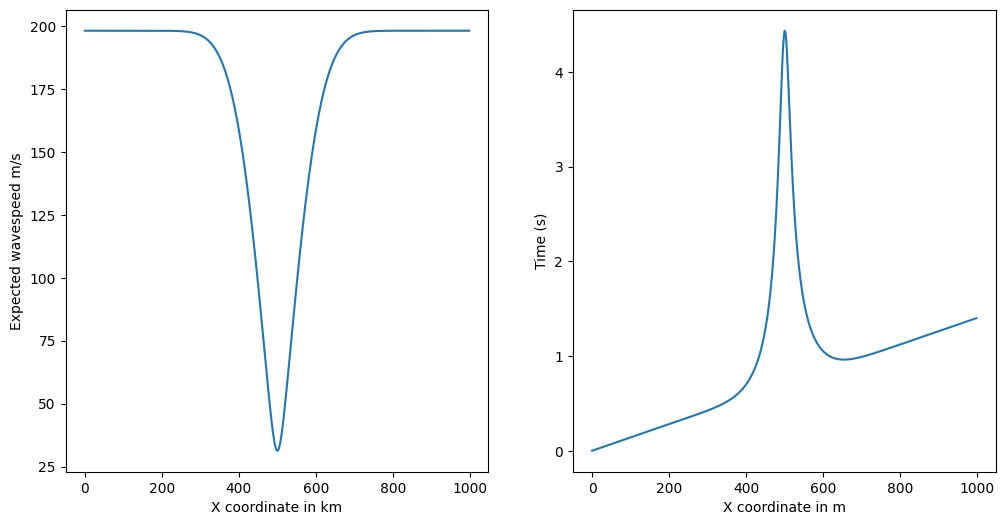

In [133]:
# CREATE FIGURES HERE
plt.figure(figsize=(12,6))
cp = np.sqrt(g*H['g'])
plt.subplot(1, 2, 1)
plt.plot(x/kilometer, cp)
plt.ylabel("Expected wavespeed m/s")
plt.xlabel("X coordinate in km")
#plt.vlines(500, 25, max(cp), 'orange', '--', label='Seamount center')
#len(H['g']) # = 512
plt.subplot(1, 2, 2)
plt.plot(x/kilometer, (x/cp)/hour)
plt.ylabel("Time (s)")
plt.xlabel("X coordinate in m")

2024-12-19 18:04:22,329 matplotlib.legend 0/1 WARNING :: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


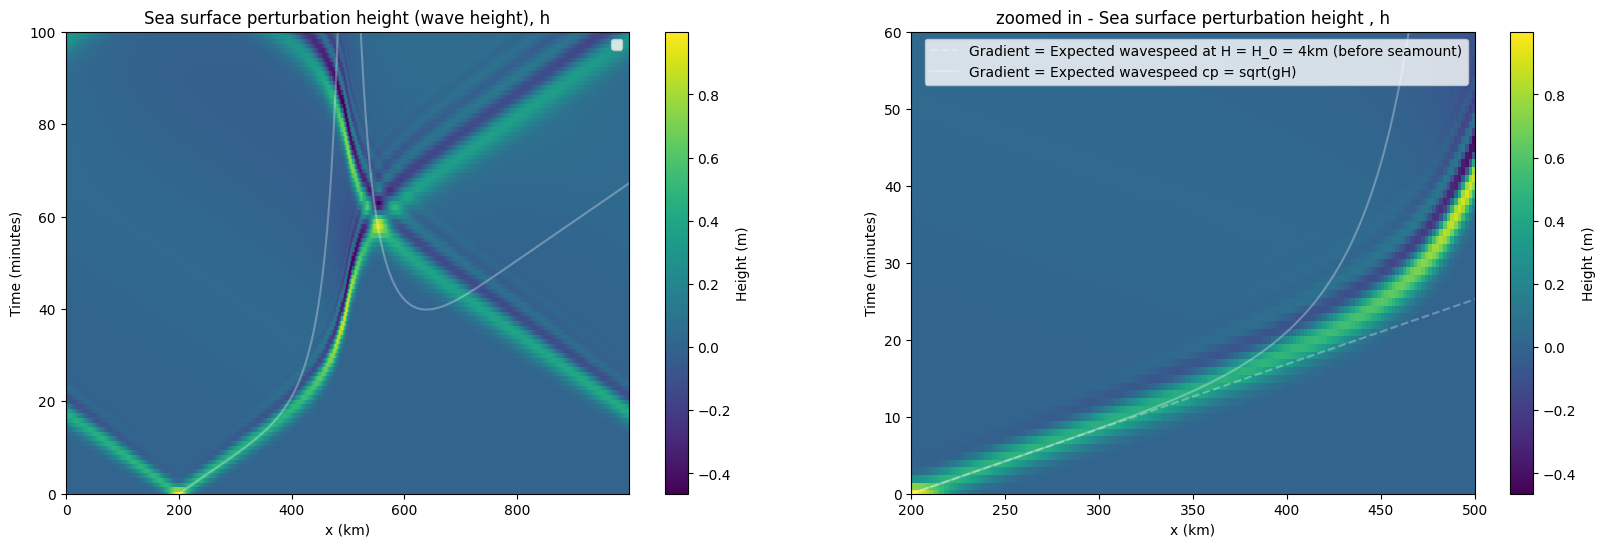

In [154]:
#h_save.shape # = (101, 512)
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)

minutes_array = np.array(t_save)/minute
#plt.pcolor(x/kilometer, minutes_array, h_save)
plt.pcolor(x/kilometer, np.array(t_save)/minute, h_save)
plt.xlabel("x (km)")
plt.ylabel("Time (minutes)")
plt.title("Sea surface perturbation height (wave height), h")

#plt.plot(x/kilometer, (kilometer/(cp[0]*60)) * (x/kilometer - 200), c = "white", alpha = 0.3, label = "Gradient = Expected wavespeed")
plt.plot(x/kilometer, ((x-200*kilometer)/cp)/minute, c = "white", alpha = 0.3)
plt.ylim(0,max(np.array(t_save)/minute))
plt.legend()
plt.colorbar(label = "Height (m)")

plt.subplot(1, 2, 2)
plt.pcolor(x/kilometer, minutes_array, h_save)
plt.xlabel("x (km)")
plt.ylabel("Time (minutes)")
plt.title("zoomed in - Sea surface perturbation height , h")

plt.plot(x/kilometer, (kilometer/(cp[0]*60)) * (x/kilometer - 200), '--',c = "white", alpha = 0.3, label = "Gradient = Expected wavespeed at H = H_0 = 4km (before seamount)")

#plot line to show that wave speed is constant before approaching/hitting the sea mount
# wavespeed slows down when approaching shallow water (then the wave accelerates and depth increases again)
# As we're considering a tsunami scenario we're only interested the int behavior of the wave as it approaches shallow water so from x < 500
#from above figure wavespeed = 198.09088823 m/s   seconds = cp[0]
# on our plot we want the reciprocal of this as the gradient of the line
plt.plot(x/kilometer, ((x-200*kilometer)/cp)/minute, c = "white", alpha = 0.3, label = "Gradient = Expected wavespeed cp = sqrt(gH)")

plt.xlim(200,500)
plt.ylim(0,60)
plt.legend()
plt.colorbar(label = "Height (m)")
plt.show()

COMMENT ON RESULTS

From the wave height colour plot wave speed can be interpreted as the reciprocal of the gradient of the line that follows where wave height is highest at each time (Note: Ignore the lines which appear to have negative gradient - they are remenants from the periodic inital condition). The seamount in located at 500m and we can see  

We can see that the wave appears to have constant speed before approaching the seamount and this constnat speed is the calcualted expected wvae speed (phase speed) as given by 1/gradient of the white line mount as approximated by the white line. Upon approaching shallow waters the wave deccelerates rapidly (steep gradient => deceleration).

## 2.  2D Shallow water equations

Now, let's see how things change if we move to two dimensions. The script below solves the 2D shallow water equations:

$$ \partial_t u + g \partial_x(h) = - u*\partial_x u - v*\partial_y u$$
$$ \partial_t u + g \partial_y(h) = - u*\partial_x v - v*\partial_y v$$
$$ \partial_t h + H (\partial_x(u) + \partial_y(v)) = -\partial_x(h*u) - \partial_y(h*v)$$

We will solve these equations in a square domain with periodic boundary conditions. We will again initialize with a Gaussian height disturbance and with no water motion, but this time in 2D:

$$ h=e^{-(x^2+y^2)/w^2} $$
$$ u=0 $$
$$ v=0 $$

### 2.1  Dedalus script to solve the 2D shallow water equations

In [ ]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size in x
Ly = 1000 * kilometer # The domain size in y
Nx = 64 # The number of gridpoints in x
Ny = 64 # The number of gridpoints in y
g = 9.81 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Reference ocean depth
width = 100 * kilometer # Set the width of the initial Gaussian

timestep = 60 * second # Specify the timestep
stop_sim_time = 30 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(-Lx/2, Lx/2), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=3/2)

x, y = dist.local_grids(xbasis, ybasis)

# Fields
u = dist.Field(name='u', bases=(xbasis, ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
h = dist.Field(name='h', bases=(xbasis, ybasis))

# Initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
v.change_scales(1)
h['g'] = np.exp(-(x**2+y**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
u['g'] = 0
v['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, coords['x'])
dy = lambda a: dedalus.Differentiate(a, coords['y'])

# Problem
problem = dedalus.IVP([u, v, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u) - v*dy(u)")
problem.add_equation("dt(v) + g*dy(h) = - u*dx(v) - v*dy(v)")
problem.add_equation("dt(h) + H*(dx(u) + dy(v)) = - dx(h*u) - dy(h*v)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')
snapshots.add_task(v, name='v')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

INFO:subsystems:Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 1s, Rate: 3.4e+01/s


2024-12-18 20:08:53,774 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 1s, Rate: 3.4e+01/s


INFO:subsystems:Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 1s, Rate: 5.2e+01/s


2024-12-18 20:08:53,821 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 1s, Rate: 5.2e+01/s


INFO:subsystems:Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 5.8e+01/s


2024-12-18 20:08:53,881 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 5.8e+01/s


INFO:subsystems:Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 5.8e+01/s


2024-12-18 20:08:53,950 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 5.8e+01/s


INFO:subsystems:Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 5.8e+01/s


2024-12-18 20:08:54,021 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 5.8e+01/s


INFO:subsystems:Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 5.9e+01/s


2024-12-18 20:08:54,082 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 5.9e+01/s


INFO:subsystems:Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 6.1e+01/s


2024-12-18 20:08:54,140 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 6.1e+01/s


INFO:subsystems:Building subproblem matrices 28/32 (~88%) Elapsed: 0s, Remaining: 0s, Rate: 6.1e+01/s


2024-12-18 20:08:54,204 subsystems 0/1 INFO :: Building subproblem matrices 28/32 (~88%) Elapsed: 0s, Remaining: 0s, Rate: 6.1e+01/s


INFO:subsystems:Building subproblem matrices 32/32 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 6.1e+01/s


2024-12-18 20:08:54,266 subsystems 0/1 INFO :: Building subproblem matrices 32/32 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 6.1e+01/s


INFO:__main__:Starting main loop


2024-12-18 20:08:54,277 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-12-18 20:08:55,984 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 30


2024-12-18 20:08:55,999 solvers 0/1 INFO :: Final iteration: 30


INFO:solvers:Final sim time: 1800.0


2024-12-18 20:08:56,018 solvers 0/1 INFO :: Final sim time: 1800.0


INFO:solvers:Setup time (init - iter 0): 0.8654 sec


2024-12-18 20:08:56,033 solvers 0/1 INFO :: Setup time (init - iter 0): 0.8654 sec


INFO:solvers:Warmup time (iter 0-10): 0.4986 sec


2024-12-18 20:08:56,057 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.4986 sec


INFO:solvers:Run time (iter 10-end): 0.9237 sec


2024-12-18 20:08:56,087 solvers 0/1 INFO :: Run time (iter 10-end): 0.9237 sec


INFO:solvers:CPU time (iter 10-end): 0.0002566 cpu-hr


2024-12-18 20:08:56,099 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0002566 cpu-hr


INFO:solvers:Speed: 5.156e+05 mode-stages/cpu-sec


2024-12-18 20:08:56,108 solvers 0/1 INFO :: Speed: 5.156e+05 mode-stages/cpu-sec


### 2.2  Plotting
The code below will make a movie of the height as a function of x and y

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-12-18 20:08:58,869 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpwc0gpfan/temp.m4v


2024-12-18 20:08:58,876 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpwc0gpfan/temp.m4v


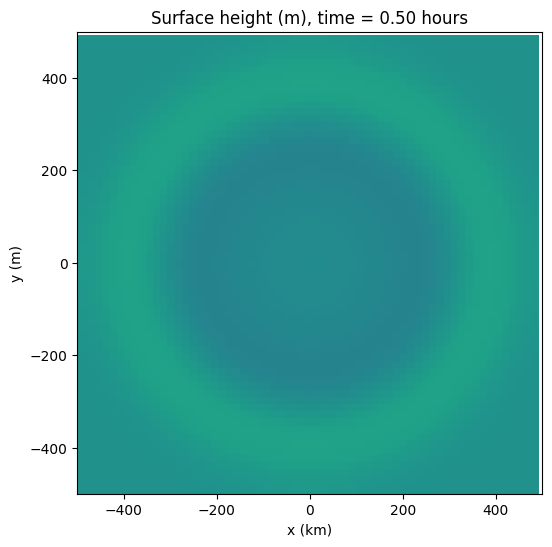

In [ ]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the x and y coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf # clear the figure before plotting the next frame
    height = plt.pcolor(X/(1*kilometer), Y/(1*kilometer), h_save[n,:,:], vmin=-1, vmax=1)
    # Specify the axis limits and labels
    plt.xlim((-Lx/2 / (1*kilometer),Lx/2 / (1*kilometer)))
    plt.ylim((-Ly/2 / (1*kilometer),Ly/2 / (1*kilometer)))
    plt.xlabel('x (km)')
    plt.ylabel('y (m)')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 2.3 Student investigation
<a id='section2pt3'></a>
Notice how the amplitude of the Tsunami wave decreases with distance from the source location. In the cell below, make a prediction for how the wave amplitude will vary as a function of distance from the origin (x=0, y=0) using conservation of energy. Then, make a plot or plots comparing your prediction for the wave amplitude compared with the results from the simulation.

Try out several different possible initial conditions for the surface height, $h$. How does the shape of the resulting waves change?

energy proportional to inital amplitude ^2 \\
wave intensity prop to currnet amplitude ^2 \\
wave intenisty = energy / area, area = 2pi r \\
r = sq (x^2 + y^2) \\
substitue to get realtionship between inital, current amplitude and r. \\

$h = h_0 / \sqrt{r}$

Due to conservation of energy the total amount of energy within the wave area remains constant. The wave spread in a ring/circle and the area gets larger with time. The amplitude of the wave decreases as the wave spreads more/as its area ($A$), and radius ($r$) increase. So the energy is spread over a larger area and we can describe this as wave intenisty decreasing with time/as area increases.

ADD PREDICTION OF WAVE AMPLITUDE HERE (a few sentences and/or equations):

Energy contained in the wave $E$ is constant over time from all distances of the waves from its source reprsented by the function $r = r(t)$.
The area of the ring covered by the wave is $A(r) = \pi(r+ \delta r)^2 - \pi r^2$ where $r$ is the inner ring radius and $r+\delta r$ is the outer ring radius.  
Wave amplitude is given by $h=h(r)$ and and initially $E ∝ h_0^2$.
We can define wave intensity as $I(r) = E/A(r)$, a function that decays with distance, similar to have wave amplitude decays with distance by not exactly because intenisty depends on area which involves r^2 terms.
So we actually have $I(r) ∝ h^2(r)$.

Putting these relationships together we get

$$\begin{equation} \left\{ \begin{aligned} & I(r) = E/A(r) ∝ h_0^2 / A(r) \\ & I(r) ∝ h^2(r) \\ \end{aligned} \right. \end{equation}$$

<!-- $$I(r) = E/A(r) ∝ h_0^2 / A(r),$$
$$I(r) ∝ h^2(r)$$ -->
$$⇒$$

$$ h^2_0/A(r) \propto h^2(r) $$

$$⇒$$

$$ \frac{h_0}{\sqrt{\pi(r+ \delta r)^2 - \pi r^2}} \propto h(r) $$

$$⇒$$

$$ \frac{h_0}{\sqrt{(r+ \delta r)^2 - r^2}} \propto h(r) $$

$$⇒$$

$$ \frac{h_0}{\sqrt{2r\delta r + (\delta r)^2}} \propto h(r) .$$

Since we don't have damping in this equation and from looking at the above animation we see that the width of the perturbation doesn't change over the course of the simulation so we can set $\delta_r = $ width which is a constant and in the original code is set as $100km$.

To solve for the consatnt of proportionality consider that initally $h(r_0) = C \frac{h_0}{\delta r} = h_0 ⇒ c = δ r$. Therefore out expression for predicted wave amplitude is

$$ h(r) = δr \frac{h_0}{\sqrt{2r\delta r + (\delta r)^2}}.$$


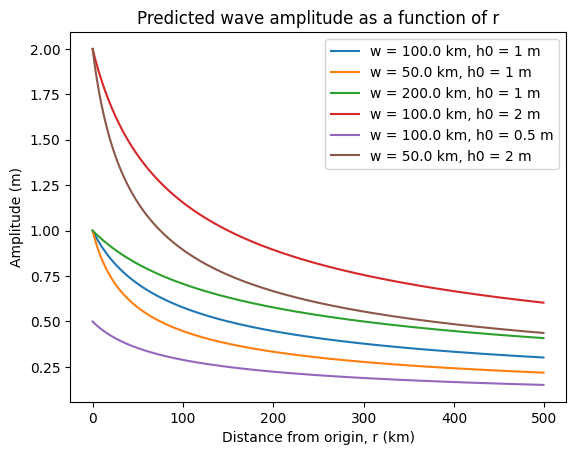

In [118]:
# ADD CODE TO MAKE PLOTS HERE
r = np.arange(0, 500000, 1000) # r in kilometres

# inital conditions
delta_r_list = [100*kilometer, 50*kilometer, 200*kilometer, 100*kilometer, 100*kilometer, 50*kilometer]# initial perturbation width
h_0_list = [1, 1, 1, 2, 0.5, 2] # inital pertubation amplitude

for i in range(0, len(delta_r_list)):
  delta_r = delta_r_list[i]
  h_0 = h_0_list[i]
  plt.plot(r/kilometer, delta_r*h_0/(np.sqrt(2*r*delta_r + delta_r**2)), label = f"w = {delta_r/kilometer} km, h0 = {h_0} m")

plt.title("Predicted wave amplitude as a function of r")
plt.xlabel("Distance from origin, r (km)")
plt.ylabel("Amplitude (m)")
plt.legend()

ADD DISCUSSION HERE (~1 paragraph)

Wave speed rapidly decreases with distance from thr origin. Defining $r = \sqrt{x^2 + y^2}$ we have that wave amplitude is inversly proportions to the $\sqrt{r}$

## 3. Shallow water equations on a sphere

Of course the Earth isn't a flat plane. A great strength of Dedalus is its flexibility to solve equations in various geometries. The script below solves the 2D shallow water equations on a spherical shell, where the azimuth and colatitude are the independent variables. The colatitude is the complementary angle to the latitude such that the colatitude is $0^\circ$ at the North Pole, $90^\circ$ at the Equator, and $180^\circ$ at the South Pole. The spherical geometry also allows us to take into account the Earth's rotation in a realistic way.

Specifically, we will solve the following equations:
$$ \partial_t \mathbf{u} + g \nabla h + 2 \Omega \hat{\mathbf{z}} \times \mathbf{u} = -\mathbf{u} \cdot \nabla \mathbf{u} $$
$$ \partial_t + H \nabla \cdot \mathbf{u} = -\nabla \cdot (h \mathbf{u}) $$

where $\mathbf{u}$ is the velocity vector, $\Omega$ is the Earth's angular velocity (in radians per second), and $\hat{\mathbf{z}}$ is a unit vector aligned with the North Pole. Note that we have written the equations above in vector form. Dedalus includes vector calculus operators that make it very natural to solve equations like this without worrying about the particular form of the vector operators in a curvilinear coordinate system.

### 3.1  Dedalus script for 2D shallow water equations on a sphere

In [ ]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Parameters
Nphi = 128 # Number of gridpoints in phi (longitude)
Ntheta = 64 # Number of gridpoints in theta (colatitude)
R = 6.37122e3 * kilometer
Omega = 2 * np.pi / (1 * day) # Earth's angular velocity in radians per second
g = 9.80616 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Depth of the ocean
width = 2*np.pi*10/360 # Width of the initial Gaussian in radians
phi0 = np.pi # Longitude of the initial Gaussian height perturbation in radians
theta0 = np.pi/4 # Colatitude of the initial Gaussian height perturbation in radians

timestep = 600 * second
stop_sim_time = 10 * day

# Bases
coords = dedalus.S2Coordinates('phi', 'theta')
dist = dedalus.Distributor(coords, dtype=np.float64)
basis = dedalus.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=3/2, dtype=np.float64)

# Define the coordinates
phi, theta = dist.local_grids(basis) # Longitude and colatitude
lat = 360*(np.pi / 2 - theta)/(2*np.pi)  # latitude in degrees

# Fields
u = dist.VectorField(coords, name='u', bases=basis)
h = dist.Field(name='h', bases=basis)

# Operators
# First, create an operator to perform the cross product: "z x ", where z is the local vertical unit vector
# The "skew" operator performs a 90 degree rotation of a vector field,
# so that skew([u,v]) = [-v, u].  MulCosine multiplies by the cosine of the latitude
zcross = lambda A: dedalus.MulCosine(dedalus.skew(A))

# Set the initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
h['g'] = np.exp(-((phi-phi0)**2+(theta-theta0)**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
# Set the initial velocity to zero
u['g'][0] = 0 # the x-component of the velocity
u['g'][1] = 0 # the y-component of the velocity

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*grad(h) + 2*Omega*zcross(u) = - u@grad(u)")
problem.add_equation("dt(h) + H*div(u) = - div(h*u)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save = np.array(h_save)

INFO:subsystems:Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 3s, Rate: 2.3e+01/s


2024-12-18 21:43:28,695 subsystems 0/1 INFO :: Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 3s, Rate: 2.3e+01/s


INFO:subsystems:Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 2s, Rate: 3.4e+01/s


2024-12-18 21:43:28,856 subsystems 0/1 INFO :: Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 2s, Rate: 3.4e+01/s


INFO:subsystems:Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 3.5e+01/s


2024-12-18 21:43:29,053 subsystems 0/1 INFO :: Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 3.5e+01/s


INFO:subsystems:Building subproblem matrices 21/63 (~33%) Elapsed: 1s, Remaining: 1s, Rate: 3.5e+01/s


2024-12-18 21:43:29,250 subsystems 0/1 INFO :: Building subproblem matrices 21/63 (~33%) Elapsed: 1s, Remaining: 1s, Rate: 3.5e+01/s


INFO:subsystems:Building subproblem matrices 28/63 (~44%) Elapsed: 1s, Remaining: 1s, Rate: 3.3e+01/s


2024-12-18 21:43:29,491 subsystems 0/1 INFO :: Building subproblem matrices 28/63 (~44%) Elapsed: 1s, Remaining: 1s, Rate: 3.3e+01/s


INFO:subsystems:Building subproblem matrices 35/63 (~56%) Elapsed: 2s, Remaining: 1s, Rate: 2.0e+01/s


2024-12-18 21:43:30,439 subsystems 0/1 INFO :: Building subproblem matrices 35/63 (~56%) Elapsed: 2s, Remaining: 1s, Rate: 2.0e+01/s


INFO:subsystems:Building subproblem matrices 42/63 (~67%) Elapsed: 2s, Remaining: 1s, Rate: 2.0e+01/s


2024-12-18 21:43:30,789 subsystems 0/1 INFO :: Building subproblem matrices 42/63 (~67%) Elapsed: 2s, Remaining: 1s, Rate: 2.0e+01/s


INFO:subsystems:Building subproblem matrices 49/63 (~78%) Elapsed: 3s, Remaining: 1s, Rate: 1.6e+01/s


2024-12-18 21:43:31,710 subsystems 0/1 INFO :: Building subproblem matrices 49/63 (~78%) Elapsed: 3s, Remaining: 1s, Rate: 1.6e+01/s


INFO:subsystems:Building subproblem matrices 56/63 (~89%) Elapsed: 3s, Remaining: 0s, Rate: 1.7e+01/s


2024-12-18 21:43:32,021 subsystems 0/1 INFO :: Building subproblem matrices 56/63 (~89%) Elapsed: 3s, Remaining: 0s, Rate: 1.7e+01/s


INFO:subsystems:Building subproblem matrices 63/63 (~100%) Elapsed: 4s, Remaining: 0s, Rate: 1.7e+01/s


2024-12-18 21:43:32,332 subsystems 0/1 INFO :: Building subproblem matrices 63/63 (~100%) Elapsed: 4s, Remaining: 0s, Rate: 1.7e+01/s


INFO:__main__:Starting main loop


2024-12-18 21:43:32,341 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=6.000000e+02, dt=6.000000e+02


2024-12-18 21:43:36,860 __main__ 0/1 INFO :: Iteration=1, Time=6.000000e+02, dt=6.000000e+02


INFO:__main__:Iteration=11, Time=6.600000e+03, dt=6.000000e+02


2024-12-18 21:43:37,761 __main__ 0/1 INFO :: Iteration=11, Time=6.600000e+03, dt=6.000000e+02


INFO:__main__:Iteration=21, Time=1.260000e+04, dt=6.000000e+02


2024-12-18 21:43:38,309 __main__ 0/1 INFO :: Iteration=21, Time=1.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=31, Time=1.860000e+04, dt=6.000000e+02


2024-12-18 21:43:38,875 __main__ 0/1 INFO :: Iteration=31, Time=1.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=41, Time=2.460000e+04, dt=6.000000e+02


2024-12-18 21:43:39,429 __main__ 0/1 INFO :: Iteration=41, Time=2.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=51, Time=3.060000e+04, dt=6.000000e+02


2024-12-18 21:43:40,004 __main__ 0/1 INFO :: Iteration=51, Time=3.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=61, Time=3.660000e+04, dt=6.000000e+02


2024-12-18 21:43:40,546 __main__ 0/1 INFO :: Iteration=61, Time=3.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=71, Time=4.260000e+04, dt=6.000000e+02


2024-12-18 21:43:41,097 __main__ 0/1 INFO :: Iteration=71, Time=4.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=81, Time=4.860000e+04, dt=6.000000e+02


2024-12-18 21:43:41,640 __main__ 0/1 INFO :: Iteration=81, Time=4.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=91, Time=5.460000e+04, dt=6.000000e+02


2024-12-18 21:43:42,206 __main__ 0/1 INFO :: Iteration=91, Time=5.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=101, Time=6.060000e+04, dt=6.000000e+02


2024-12-18 21:43:42,762 __main__ 0/1 INFO :: Iteration=101, Time=6.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=111, Time=6.660000e+04, dt=6.000000e+02


2024-12-18 21:43:43,419 __main__ 0/1 INFO :: Iteration=111, Time=6.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=121, Time=7.260000e+04, dt=6.000000e+02


2024-12-18 21:43:44,235 __main__ 0/1 INFO :: Iteration=121, Time=7.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=131, Time=7.860000e+04, dt=6.000000e+02


2024-12-18 21:43:45,030 __main__ 0/1 INFO :: Iteration=131, Time=7.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=141, Time=8.460000e+04, dt=6.000000e+02


2024-12-18 21:43:45,877 __main__ 0/1 INFO :: Iteration=141, Time=8.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=151, Time=9.060000e+04, dt=6.000000e+02


2024-12-18 21:43:46,749 __main__ 0/1 INFO :: Iteration=151, Time=9.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=161, Time=9.660000e+04, dt=6.000000e+02


2024-12-18 21:43:47,364 __main__ 0/1 INFO :: Iteration=161, Time=9.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=171, Time=1.026000e+05, dt=6.000000e+02


2024-12-18 21:43:47,938 __main__ 0/1 INFO :: Iteration=171, Time=1.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=181, Time=1.086000e+05, dt=6.000000e+02


2024-12-18 21:43:48,512 __main__ 0/1 INFO :: Iteration=181, Time=1.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=191, Time=1.146000e+05, dt=6.000000e+02


2024-12-18 21:43:49,060 __main__ 0/1 INFO :: Iteration=191, Time=1.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=201, Time=1.206000e+05, dt=6.000000e+02


2024-12-18 21:43:49,637 __main__ 0/1 INFO :: Iteration=201, Time=1.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=211, Time=1.266000e+05, dt=6.000000e+02


2024-12-18 21:43:50,185 __main__ 0/1 INFO :: Iteration=211, Time=1.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=221, Time=1.326000e+05, dt=6.000000e+02


2024-12-18 21:43:50,735 __main__ 0/1 INFO :: Iteration=221, Time=1.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=231, Time=1.386000e+05, dt=6.000000e+02


2024-12-18 21:43:51,316 __main__ 0/1 INFO :: Iteration=231, Time=1.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=241, Time=1.446000e+05, dt=6.000000e+02


2024-12-18 21:43:51,857 __main__ 0/1 INFO :: Iteration=241, Time=1.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=251, Time=1.506000e+05, dt=6.000000e+02


2024-12-18 21:43:52,408 __main__ 0/1 INFO :: Iteration=251, Time=1.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=261, Time=1.566000e+05, dt=6.000000e+02


2024-12-18 21:43:52,948 __main__ 0/1 INFO :: Iteration=261, Time=1.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=271, Time=1.626000e+05, dt=6.000000e+02


2024-12-18 21:43:53,520 __main__ 0/1 INFO :: Iteration=271, Time=1.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=281, Time=1.686000e+05, dt=6.000000e+02


2024-12-18 21:43:54,057 __main__ 0/1 INFO :: Iteration=281, Time=1.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=291, Time=1.746000e+05, dt=6.000000e+02


2024-12-18 21:43:54,601 __main__ 0/1 INFO :: Iteration=291, Time=1.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=301, Time=1.806000e+05, dt=6.000000e+02


2024-12-18 21:43:55,152 __main__ 0/1 INFO :: Iteration=301, Time=1.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=311, Time=1.866000e+05, dt=6.000000e+02


2024-12-18 21:43:55,711 __main__ 0/1 INFO :: Iteration=311, Time=1.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=321, Time=1.926000e+05, dt=6.000000e+02


2024-12-18 21:43:56,248 __main__ 0/1 INFO :: Iteration=321, Time=1.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=331, Time=1.986000e+05, dt=6.000000e+02


2024-12-18 21:43:56,796 __main__ 0/1 INFO :: Iteration=331, Time=1.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=341, Time=2.046000e+05, dt=6.000000e+02


2024-12-18 21:43:57,576 __main__ 0/1 INFO :: Iteration=341, Time=2.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=351, Time=2.106000e+05, dt=6.000000e+02


2024-12-18 21:43:58,366 __main__ 0/1 INFO :: Iteration=351, Time=2.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=361, Time=2.166000e+05, dt=6.000000e+02


2024-12-18 21:43:59,171 __main__ 0/1 INFO :: Iteration=361, Time=2.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=371, Time=2.226000e+05, dt=6.000000e+02


2024-12-18 21:44:00,018 __main__ 0/1 INFO :: Iteration=371, Time=2.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=381, Time=2.286000e+05, dt=6.000000e+02


2024-12-18 21:44:00,736 __main__ 0/1 INFO :: Iteration=381, Time=2.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=391, Time=2.346000e+05, dt=6.000000e+02


2024-12-18 21:44:01,268 __main__ 0/1 INFO :: Iteration=391, Time=2.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=401, Time=2.406000e+05, dt=6.000000e+02


2024-12-18 21:44:01,829 __main__ 0/1 INFO :: Iteration=401, Time=2.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=411, Time=2.466000e+05, dt=6.000000e+02


2024-12-18 21:44:02,365 __main__ 0/1 INFO :: Iteration=411, Time=2.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=421, Time=2.526000e+05, dt=6.000000e+02


2024-12-18 21:44:02,917 __main__ 0/1 INFO :: Iteration=421, Time=2.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=431, Time=2.586000e+05, dt=6.000000e+02


2024-12-18 21:44:03,460 __main__ 0/1 INFO :: Iteration=431, Time=2.586000e+05, dt=6.000000e+02


INFO:__main__:Iteration=441, Time=2.646000e+05, dt=6.000000e+02


2024-12-18 21:44:04,024 __main__ 0/1 INFO :: Iteration=441, Time=2.646000e+05, dt=6.000000e+02


INFO:__main__:Iteration=451, Time=2.706000e+05, dt=6.000000e+02


2024-12-18 21:44:04,557 __main__ 0/1 INFO :: Iteration=451, Time=2.706000e+05, dt=6.000000e+02


INFO:__main__:Iteration=461, Time=2.766000e+05, dt=6.000000e+02


2024-12-18 21:44:05,135 __main__ 0/1 INFO :: Iteration=461, Time=2.766000e+05, dt=6.000000e+02


INFO:__main__:Iteration=471, Time=2.826000e+05, dt=6.000000e+02


2024-12-18 21:44:05,675 __main__ 0/1 INFO :: Iteration=471, Time=2.826000e+05, dt=6.000000e+02


INFO:__main__:Iteration=481, Time=2.886000e+05, dt=6.000000e+02


2024-12-18 21:44:06,239 __main__ 0/1 INFO :: Iteration=481, Time=2.886000e+05, dt=6.000000e+02


INFO:__main__:Iteration=491, Time=2.946000e+05, dt=6.000000e+02


2024-12-18 21:44:06,806 __main__ 0/1 INFO :: Iteration=491, Time=2.946000e+05, dt=6.000000e+02


INFO:__main__:Iteration=501, Time=3.006000e+05, dt=6.000000e+02


2024-12-18 21:44:07,389 __main__ 0/1 INFO :: Iteration=501, Time=3.006000e+05, dt=6.000000e+02


INFO:__main__:Iteration=511, Time=3.066000e+05, dt=6.000000e+02


2024-12-18 21:44:07,974 __main__ 0/1 INFO :: Iteration=511, Time=3.066000e+05, dt=6.000000e+02


INFO:__main__:Iteration=521, Time=3.126000e+05, dt=6.000000e+02


2024-12-18 21:44:08,522 __main__ 0/1 INFO :: Iteration=521, Time=3.126000e+05, dt=6.000000e+02


INFO:__main__:Iteration=531, Time=3.186000e+05, dt=6.000000e+02


2024-12-18 21:44:09,087 __main__ 0/1 INFO :: Iteration=531, Time=3.186000e+05, dt=6.000000e+02


INFO:__main__:Iteration=541, Time=3.246000e+05, dt=6.000000e+02


2024-12-18 21:44:09,623 __main__ 0/1 INFO :: Iteration=541, Time=3.246000e+05, dt=6.000000e+02


INFO:__main__:Iteration=551, Time=3.306000e+05, dt=6.000000e+02


2024-12-18 21:44:10,190 __main__ 0/1 INFO :: Iteration=551, Time=3.306000e+05, dt=6.000000e+02


INFO:__main__:Iteration=561, Time=3.366000e+05, dt=6.000000e+02


2024-12-18 21:44:10,889 __main__ 0/1 INFO :: Iteration=561, Time=3.366000e+05, dt=6.000000e+02


INFO:__main__:Iteration=571, Time=3.426000e+05, dt=6.000000e+02


2024-12-18 21:44:11,703 __main__ 0/1 INFO :: Iteration=571, Time=3.426000e+05, dt=6.000000e+02


INFO:__main__:Iteration=581, Time=3.486000e+05, dt=6.000000e+02


2024-12-18 21:44:12,503 __main__ 0/1 INFO :: Iteration=581, Time=3.486000e+05, dt=6.000000e+02


INFO:__main__:Iteration=591, Time=3.546000e+05, dt=6.000000e+02


2024-12-18 21:44:13,340 __main__ 0/1 INFO :: Iteration=591, Time=3.546000e+05, dt=6.000000e+02


INFO:__main__:Iteration=601, Time=3.606000e+05, dt=6.000000e+02


2024-12-18 21:44:14,203 __main__ 0/1 INFO :: Iteration=601, Time=3.606000e+05, dt=6.000000e+02


INFO:__main__:Iteration=611, Time=3.666000e+05, dt=6.000000e+02


2024-12-18 21:44:14,785 __main__ 0/1 INFO :: Iteration=611, Time=3.666000e+05, dt=6.000000e+02


INFO:__main__:Iteration=621, Time=3.726000e+05, dt=6.000000e+02


2024-12-18 21:44:15,334 __main__ 0/1 INFO :: Iteration=621, Time=3.726000e+05, dt=6.000000e+02


INFO:__main__:Iteration=631, Time=3.786000e+05, dt=6.000000e+02


2024-12-18 21:44:15,881 __main__ 0/1 INFO :: Iteration=631, Time=3.786000e+05, dt=6.000000e+02


INFO:__main__:Iteration=641, Time=3.846000e+05, dt=6.000000e+02


2024-12-18 21:44:16,432 __main__ 0/1 INFO :: Iteration=641, Time=3.846000e+05, dt=6.000000e+02


INFO:__main__:Iteration=651, Time=3.906000e+05, dt=6.000000e+02


2024-12-18 21:44:16,996 __main__ 0/1 INFO :: Iteration=651, Time=3.906000e+05, dt=6.000000e+02


INFO:__main__:Iteration=661, Time=3.966000e+05, dt=6.000000e+02


2024-12-18 21:44:17,561 __main__ 0/1 INFO :: Iteration=661, Time=3.966000e+05, dt=6.000000e+02


INFO:__main__:Iteration=671, Time=4.026000e+05, dt=6.000000e+02


2024-12-18 21:44:18,113 __main__ 0/1 INFO :: Iteration=671, Time=4.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=681, Time=4.086000e+05, dt=6.000000e+02


2024-12-18 21:44:18,692 __main__ 0/1 INFO :: Iteration=681, Time=4.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=691, Time=4.146000e+05, dt=6.000000e+02


2024-12-18 21:44:19,237 __main__ 0/1 INFO :: Iteration=691, Time=4.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=701, Time=4.206000e+05, dt=6.000000e+02


2024-12-18 21:44:19,808 __main__ 0/1 INFO :: Iteration=701, Time=4.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=711, Time=4.266000e+05, dt=6.000000e+02


2024-12-18 21:44:20,360 __main__ 0/1 INFO :: Iteration=711, Time=4.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=721, Time=4.326000e+05, dt=6.000000e+02


2024-12-18 21:44:20,941 __main__ 0/1 INFO :: Iteration=721, Time=4.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=731, Time=4.386000e+05, dt=6.000000e+02


2024-12-18 21:44:21,541 __main__ 0/1 INFO :: Iteration=731, Time=4.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=741, Time=4.446000e+05, dt=6.000000e+02


2024-12-18 21:44:22,106 __main__ 0/1 INFO :: Iteration=741, Time=4.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=751, Time=4.506000e+05, dt=6.000000e+02


2024-12-18 21:44:22,684 __main__ 0/1 INFO :: Iteration=751, Time=4.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=761, Time=4.566000e+05, dt=6.000000e+02


2024-12-18 21:44:23,252 __main__ 0/1 INFO :: Iteration=761, Time=4.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=771, Time=4.626000e+05, dt=6.000000e+02


2024-12-18 21:44:23,820 __main__ 0/1 INFO :: Iteration=771, Time=4.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=781, Time=4.686000e+05, dt=6.000000e+02


2024-12-18 21:44:24,399 __main__ 0/1 INFO :: Iteration=781, Time=4.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=791, Time=4.746000e+05, dt=6.000000e+02


2024-12-18 21:44:25,239 __main__ 0/1 INFO :: Iteration=791, Time=4.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=801, Time=4.806000e+05, dt=6.000000e+02


2024-12-18 21:44:26,041 __main__ 0/1 INFO :: Iteration=801, Time=4.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=811, Time=4.866000e+05, dt=6.000000e+02


2024-12-18 21:44:26,868 __main__ 0/1 INFO :: Iteration=811, Time=4.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=821, Time=4.926000e+05, dt=6.000000e+02


2024-12-18 21:44:27,728 __main__ 0/1 INFO :: Iteration=821, Time=4.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=831, Time=4.986000e+05, dt=6.000000e+02


2024-12-18 21:44:28,317 __main__ 0/1 INFO :: Iteration=831, Time=4.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=841, Time=5.046000e+05, dt=6.000000e+02


2024-12-18 21:44:28,895 __main__ 0/1 INFO :: Iteration=841, Time=5.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=851, Time=5.106000e+05, dt=6.000000e+02


2024-12-18 21:44:29,433 __main__ 0/1 INFO :: Iteration=851, Time=5.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=861, Time=5.166000e+05, dt=6.000000e+02


2024-12-18 21:44:29,989 __main__ 0/1 INFO :: Iteration=861, Time=5.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=871, Time=5.226000e+05, dt=6.000000e+02


2024-12-18 21:44:30,540 __main__ 0/1 INFO :: Iteration=871, Time=5.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=881, Time=5.286000e+05, dt=6.000000e+02


2024-12-18 21:44:31,120 __main__ 0/1 INFO :: Iteration=881, Time=5.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=891, Time=5.346000e+05, dt=6.000000e+02


2024-12-18 21:44:31,895 __main__ 0/1 INFO :: Iteration=891, Time=5.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=901, Time=5.406000e+05, dt=6.000000e+02


2024-12-18 21:44:32,719 __main__ 0/1 INFO :: Iteration=901, Time=5.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=911, Time=5.466000e+05, dt=6.000000e+02


2024-12-18 21:44:33,552 __main__ 0/1 INFO :: Iteration=911, Time=5.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=921, Time=5.526000e+05, dt=6.000000e+02


2024-12-18 21:44:34,421 __main__ 0/1 INFO :: Iteration=921, Time=5.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=931, Time=5.586000e+05, dt=6.000000e+02


2024-12-18 21:44:35,217 __main__ 0/1 INFO :: Iteration=931, Time=5.586000e+05, dt=6.000000e+02


INFO:__main__:Iteration=941, Time=5.646000e+05, dt=6.000000e+02


2024-12-18 21:44:35,768 __main__ 0/1 INFO :: Iteration=941, Time=5.646000e+05, dt=6.000000e+02


INFO:__main__:Iteration=951, Time=5.706000e+05, dt=6.000000e+02


2024-12-18 21:44:36,322 __main__ 0/1 INFO :: Iteration=951, Time=5.706000e+05, dt=6.000000e+02


INFO:__main__:Iteration=961, Time=5.766000e+05, dt=6.000000e+02


2024-12-18 21:44:36,871 __main__ 0/1 INFO :: Iteration=961, Time=5.766000e+05, dt=6.000000e+02


INFO:__main__:Iteration=971, Time=5.826000e+05, dt=6.000000e+02


2024-12-18 21:44:37,436 __main__ 0/1 INFO :: Iteration=971, Time=5.826000e+05, dt=6.000000e+02


INFO:__main__:Iteration=981, Time=5.886000e+05, dt=6.000000e+02


2024-12-18 21:44:38,048 __main__ 0/1 INFO :: Iteration=981, Time=5.886000e+05, dt=6.000000e+02


INFO:__main__:Iteration=991, Time=5.946000e+05, dt=6.000000e+02


2024-12-18 21:44:38,869 __main__ 0/1 INFO :: Iteration=991, Time=5.946000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1001, Time=6.006000e+05, dt=6.000000e+02


2024-12-18 21:44:39,668 __main__ 0/1 INFO :: Iteration=1001, Time=6.006000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1011, Time=6.066000e+05, dt=6.000000e+02


2024-12-18 21:44:40,497 __main__ 0/1 INFO :: Iteration=1011, Time=6.066000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1021, Time=6.126000e+05, dt=6.000000e+02


2024-12-18 21:44:41,335 __main__ 0/1 INFO :: Iteration=1021, Time=6.126000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1031, Time=6.186000e+05, dt=6.000000e+02


2024-12-18 21:44:42,047 __main__ 0/1 INFO :: Iteration=1031, Time=6.186000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1041, Time=6.246000e+05, dt=6.000000e+02


2024-12-18 21:44:42,603 __main__ 0/1 INFO :: Iteration=1041, Time=6.246000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1051, Time=6.306000e+05, dt=6.000000e+02


2024-12-18 21:44:43,157 __main__ 0/1 INFO :: Iteration=1051, Time=6.306000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1061, Time=6.366000e+05, dt=6.000000e+02


2024-12-18 21:44:43,725 __main__ 0/1 INFO :: Iteration=1061, Time=6.366000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1071, Time=6.426000e+05, dt=6.000000e+02


2024-12-18 21:44:44,259 __main__ 0/1 INFO :: Iteration=1071, Time=6.426000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1081, Time=6.486000e+05, dt=6.000000e+02


2024-12-18 21:44:44,815 __main__ 0/1 INFO :: Iteration=1081, Time=6.486000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1091, Time=6.546000e+05, dt=6.000000e+02


2024-12-18 21:44:45,348 __main__ 0/1 INFO :: Iteration=1091, Time=6.546000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1101, Time=6.606000e+05, dt=6.000000e+02


2024-12-18 21:44:45,912 __main__ 0/1 INFO :: Iteration=1101, Time=6.606000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1111, Time=6.666000e+05, dt=6.000000e+02


2024-12-18 21:44:46,455 __main__ 0/1 INFO :: Iteration=1111, Time=6.666000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1121, Time=6.726000e+05, dt=6.000000e+02


2024-12-18 21:44:47,014 __main__ 0/1 INFO :: Iteration=1121, Time=6.726000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1131, Time=6.786000e+05, dt=6.000000e+02


2024-12-18 21:44:47,544 __main__ 0/1 INFO :: Iteration=1131, Time=6.786000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1141, Time=6.846000e+05, dt=6.000000e+02


2024-12-18 21:44:48,094 __main__ 0/1 INFO :: Iteration=1141, Time=6.846000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1151, Time=6.906000e+05, dt=6.000000e+02


2024-12-18 21:44:48,643 __main__ 0/1 INFO :: Iteration=1151, Time=6.906000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1161, Time=6.966000e+05, dt=6.000000e+02


2024-12-18 21:44:49,216 __main__ 0/1 INFO :: Iteration=1161, Time=6.966000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1171, Time=7.026000e+05, dt=6.000000e+02


2024-12-18 21:44:49,778 __main__ 0/1 INFO :: Iteration=1171, Time=7.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1181, Time=7.086000e+05, dt=6.000000e+02


2024-12-18 21:44:50,309 __main__ 0/1 INFO :: Iteration=1181, Time=7.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1191, Time=7.146000e+05, dt=6.000000e+02


2024-12-18 21:44:50,862 __main__ 0/1 INFO :: Iteration=1191, Time=7.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1201, Time=7.206000e+05, dt=6.000000e+02


2024-12-18 21:44:51,425 __main__ 0/1 INFO :: Iteration=1201, Time=7.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1211, Time=7.266000e+05, dt=6.000000e+02


2024-12-18 21:44:52,092 __main__ 0/1 INFO :: Iteration=1211, Time=7.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1221, Time=7.326000e+05, dt=6.000000e+02


2024-12-18 21:44:52,920 __main__ 0/1 INFO :: Iteration=1221, Time=7.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1231, Time=7.386000e+05, dt=6.000000e+02


2024-12-18 21:44:53,735 __main__ 0/1 INFO :: Iteration=1231, Time=7.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1241, Time=7.446000e+05, dt=6.000000e+02


2024-12-18 21:44:54,596 __main__ 0/1 INFO :: Iteration=1241, Time=7.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1251, Time=7.506000e+05, dt=6.000000e+02


2024-12-18 21:44:55,400 __main__ 0/1 INFO :: Iteration=1251, Time=7.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1261, Time=7.566000e+05, dt=6.000000e+02


2024-12-18 21:44:55,948 __main__ 0/1 INFO :: Iteration=1261, Time=7.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1271, Time=7.626000e+05, dt=6.000000e+02


2024-12-18 21:44:56,507 __main__ 0/1 INFO :: Iteration=1271, Time=7.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1281, Time=7.686000e+05, dt=6.000000e+02


2024-12-18 21:44:57,097 __main__ 0/1 INFO :: Iteration=1281, Time=7.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1291, Time=7.746000e+05, dt=6.000000e+02


2024-12-18 21:44:57,679 __main__ 0/1 INFO :: Iteration=1291, Time=7.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1301, Time=7.806000e+05, dt=6.000000e+02


2024-12-18 21:44:58,273 __main__ 0/1 INFO :: Iteration=1301, Time=7.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1311, Time=7.866000e+05, dt=6.000000e+02


2024-12-18 21:44:58,853 __main__ 0/1 INFO :: Iteration=1311, Time=7.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1321, Time=7.926000e+05, dt=6.000000e+02


2024-12-18 21:44:59,423 __main__ 0/1 INFO :: Iteration=1321, Time=7.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1331, Time=7.986000e+05, dt=6.000000e+02


2024-12-18 21:44:59,987 __main__ 0/1 INFO :: Iteration=1331, Time=7.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1341, Time=8.046000e+05, dt=6.000000e+02


2024-12-18 21:45:00,549 __main__ 0/1 INFO :: Iteration=1341, Time=8.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1351, Time=8.106000e+05, dt=6.000000e+02


2024-12-18 21:45:01,117 __main__ 0/1 INFO :: Iteration=1351, Time=8.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1361, Time=8.166000e+05, dt=6.000000e+02


2024-12-18 21:45:01,689 __main__ 0/1 INFO :: Iteration=1361, Time=8.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1371, Time=8.226000e+05, dt=6.000000e+02


2024-12-18 21:45:02,254 __main__ 0/1 INFO :: Iteration=1371, Time=8.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1381, Time=8.286000e+05, dt=6.000000e+02


2024-12-18 21:45:02,810 __main__ 0/1 INFO :: Iteration=1381, Time=8.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1391, Time=8.346000e+05, dt=6.000000e+02


2024-12-18 21:45:03,360 __main__ 0/1 INFO :: Iteration=1391, Time=8.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1401, Time=8.406000e+05, dt=6.000000e+02


2024-12-18 21:45:03,926 __main__ 0/1 INFO :: Iteration=1401, Time=8.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1411, Time=8.466000e+05, dt=6.000000e+02


2024-12-18 21:45:04,478 __main__ 0/1 INFO :: Iteration=1411, Time=8.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1421, Time=8.526000e+05, dt=6.000000e+02


2024-12-18 21:45:05,033 __main__ 0/1 INFO :: Iteration=1421, Time=8.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1431, Time=8.586000e+05, dt=6.000000e+02


2024-12-18 21:45:05,766 __main__ 0/1 INFO :: Iteration=1431, Time=8.586000e+05, dt=6.000000e+02


INFO:solvers:Simulation stop time reached.


2024-12-18 21:45:06,491 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 1440


2024-12-18 21:45:06,498 solvers 0/1 INFO :: Final iteration: 1440


INFO:solvers:Final sim time: 864000.0


2024-12-18 21:45:06,505 solvers 0/1 INFO :: Final sim time: 864000.0


INFO:solvers:Setup time (init - iter 0): 7.362 sec


2024-12-18 21:45:06,510 solvers 0/1 INFO :: Setup time (init - iter 0): 7.362 sec


INFO:solvers:Warmup time (iter 0-10): 1.745 sec


2024-12-18 21:45:06,516 solvers 0/1 INFO :: Warmup time (iter 0-10): 1.745 sec


INFO:solvers:Run time (iter 10-end): 88.79 sec


2024-12-18 21:45:06,521 solvers 0/1 INFO :: Run time (iter 10-end): 88.79 sec


INFO:solvers:CPU time (iter 10-end): 0.02466 cpu-hr


2024-12-18 21:45:06,525 solvers 0/1 INFO :: CPU time (iter 10-end): 0.02466 cpu-hr


INFO:solvers:Speed: 3.895e+05 mode-stages/cpu-sec


2024-12-18 21:45:06,531 solvers 0/1 INFO :: Speed: 3.895e+05 mode-stages/cpu-sec


### 3.2  Plotting
The code below will make a movie of the height as a function of x and y

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-12-19 12:57:44,730 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpj65nco9y/temp.m4v


2024-12-19 12:57:44,742 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpj65nco9y/temp.m4v


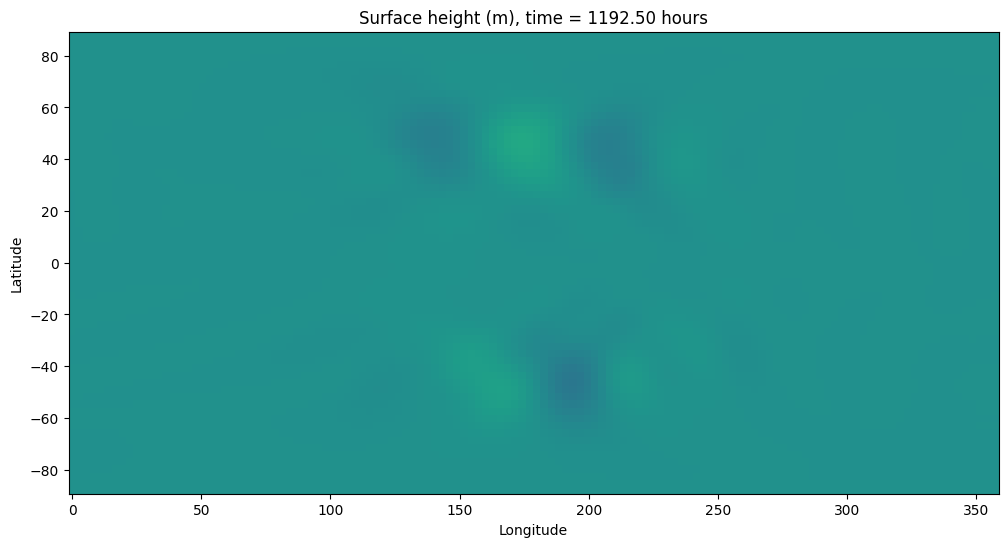

In [21]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(np.pi/2 - theta)*360/2/np.pi, np.squeeze(phi)*360/2/np.pi)

# Define an animation function
def drawframe(n):
    plt.clf()
    height = plt.pcolor(Y, X, h_save[n,:,:], vmin=-0.1, vmax=0.1)
    # Specify the axis limits and labels
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 3.3 Student investigation
<a id='section3pt3'></a>
Create a virtual tide gauge by sampling the height at a point at a latitude of 45ºN and longitude of 90ºW and plot the timeseries of the height at this point in the cells below. Notice that as the gravity waves propagate around the Earth, their shape changes. Discuss physical mechanisms that might cause the shape of the wave to change as the wave propagates.

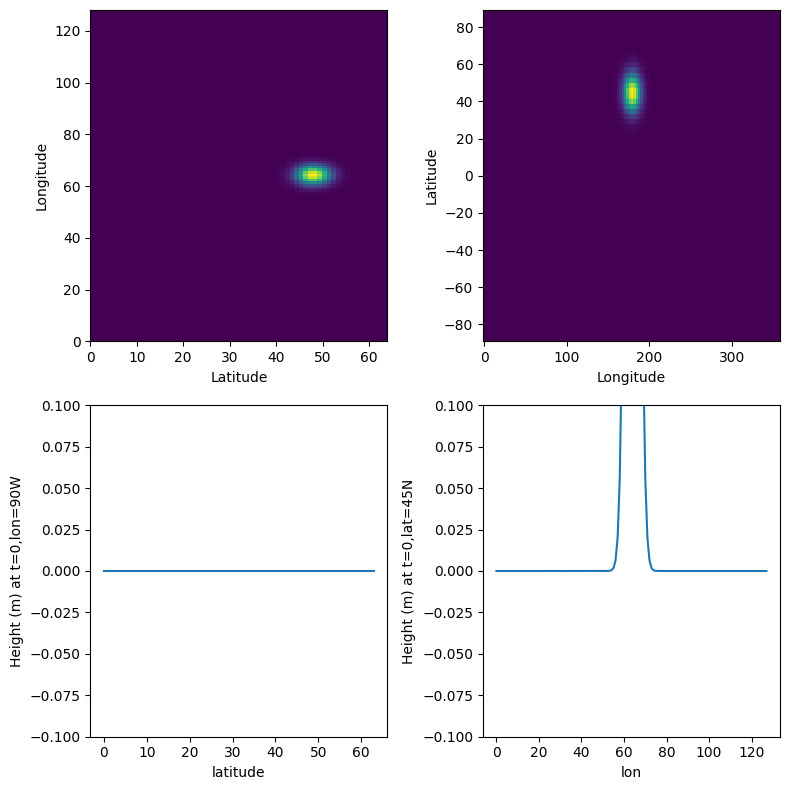

In [81]:
# h_save.shape # 1441, 128, 64 # time, lon(X), lat(Y)
#Y.shape # (129, 65) # len(Y) # 129
# X.shape # (129, 65) # len(X)
plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.pcolor(h_save[0, :, :]) # when not grid or arrays are given the first dim geos on the y axis ans the second on the x axis
plt.ylabel('Longitude')
plt.xlabel('Latitude')
plt.subplot(2, 2, 2)
plt.pcolor(Y, X, h_save[0, :, :])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.subplot(2, 2, 3)
W90 = 128*3/4 - 1 # = 95
plt.plot(h_save[0, 95, :])
plt.ylabel('Height (m) at t=0,lon=90W')
plt.xlabel('latitude')
plt.ylim(-0.1, 0.1)
plt.subplot(2, 2, 4)
N45 = (64*3/4 - 1) # = 47
plt.plot(h_save[0, :, 47]) # h_save has dimesion time, longitude then latitude
plt.ylabel('Height (m) at t=0,lat=45N')
plt.xlabel('lon')
plt.ylim(-0.1, 0.1)
plt.tight_layout()

ADD PLOTS AND DISCUSSION HERE

Text(0.5, 1.0, 'Tidal Gauge at point (45N, 90W)')

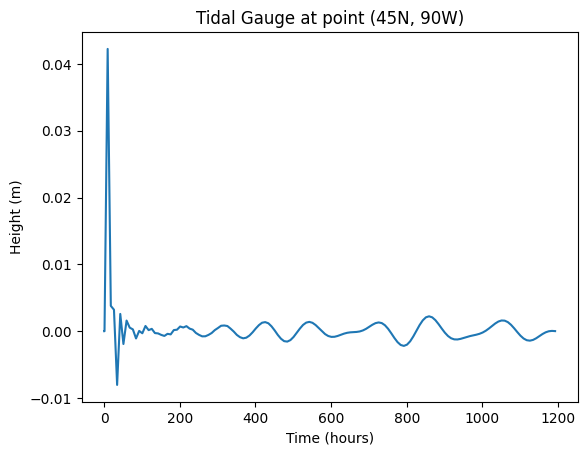

In [41]:
plt.plot(np.asarray(t_save)/hour, h_save[:, 95, 47]) # h_save has dimesion time, latitude, longitude
plt.xlabel('Time (hours)')
plt.ylabel('Height (m)')
plt.title('Tidal Gauge at point (45N, 90W)')

Discuss physical mechanisms that might cause the shape of the wave to change as the wave propagates.

In the simulation above, the Tsunami wave travels around the planet many times. In reality, the waves will partially dissipate when they reach shorelines. In the spherical shallow water equation code above (or in a new code block below), add a forcing term to the shallow water equations that damps the waves for longitudes larger than $\pm 90^\circ$. Specifically, add a forcing function to the right hand side of the height equation of the following form:

$$ - (1/\tau) f(\phi) h$$

where

$$ f(\phi) = \frac{1}{2}\left(1+tanh\left(\frac{\phi-3\pi/2}{\pi/10}\right)\right) + \frac{1}{2}\left(1-tanh\left(\frac{\phi-\pi/2}{\pi/10}\right)\right) $$

and $\phi$ is the co-latitude in radians and $\tau$ is a damping timescale. A timescale of $\tau=0.1$ days should be sufficient to damp the waves.

With this damping term active, much more slowly propagating waves should be visible. These are shallow water Rossby waves. Estimate the east/west phase speed of these Rossby waves and compare them with the phase speed that you can infer from the simulation by plotting the height, $h$, as a function of longitude and time. Discuss the spatial structure of the Rossby waves and any discrepancies that you see between your estimated and measured phase speeds.

In [155]:
# ADD CODE HERE TO SOLVE THE SHALLOW WATER EQUATIONS WITH DAMPING.
# YOU CAN START BY COPYING THE CODE ABOVE AND PASTING IT HERE

#add something on the RHS of the height equation

# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Parameters
Nphi = 128 # Number of gridpoints in phi (longitude)
Ntheta = 64 # Number of gridpoints in theta (colatitude)
R = 6.37122e3 * kilometer
Omega = 2 * np.pi / (1 * day) # Earth's angular velocity in radians per second
g = 9.80616 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Depth of the ocean
width = 2*np.pi*10/360 # Width of the initial Gaussian in radians
phi0 = np.pi # Longitude of the initial Gaussian height perturbation in radians
theta0 = np.pi/4 # Colatitude of the initial Gaussian height perturbation in radians
tau = 0.1 * day # timescale of 0.1 days

timestep = 600 * second
stop_sim_time = 10 * day

# Bases
coords = dedalus.S2Coordinates('phi', 'theta')
dist = dedalus.Distributor(coords, dtype=np.float64)
basis = dedalus.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=3/2, dtype=np.float64)

# Define the coordinates
phi, theta = dist.local_grids(basis) # Longitude and colatitude
lat = 360*(np.pi / 2 - theta)/(2*np.pi)  # latitude in degrees

# Fields
u = dist.VectorField(coords, name='u', bases=basis)
h = dist.Field(name='h', bases=basis)
#  add f as a field
f = dist.Field(name='f', bases=basis)
f['g'] = 0.5*(1 + np.tanh((phi - 3*np.pi/2)/(np.pi/10))) + 0.5*(1 - np.tanh((phi - np.pi/2)/(np.pi/10)))

# Operators
# First, create an operator to perform the cross product: "z x ", where z is the local vertical unit vector
# The "skew" operator performs a 90 degree rotation of a vector field,
# so that skew([u,v]) = [-v, u].  MulCosine multiplies by the cosine of the latitude
zcross = lambda A: dedalus.MulCosine(dedalus.skew(A))

# Set the initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
h['g'] = np.exp(-((phi-phi0)**2+(theta-theta0)**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
# Set the initial velocity to zero
u['g'][0] = 0 # the x-component of the velocity
u['g'][1] = 0 # the y-component of the velocity

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*grad(h) + 2*Omega*zcross(u) = - u@grad(u)")
problem.add_equation("dt(h) + H*div(u) = - div(h*u) - (1/tau)*f*h")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save = np.array(h_save)

INFO:subsystems:Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 2s, Rate: 3.6e+01/s


2024-12-19 18:17:04,834 subsystems 0/1 INFO :: Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 2s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 4.8e+01/s


2024-12-19 18:17:04,951 subsystems 0/1 INFO :: Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 4.8e+01/s


INFO:subsystems:Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 5.1e+01/s


2024-12-19 18:17:05,081 subsystems 0/1 INFO :: Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 5.1e+01/s


INFO:subsystems:Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 1s, Rate: 5.3e+01/s


2024-12-19 18:17:05,200 subsystems 0/1 INFO :: Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 1s, Rate: 5.3e+01/s


INFO:subsystems:Building subproblem matrices 28/63 (~44%) Elapsed: 1s, Remaining: 1s, Rate: 5.4e+01/s


2024-12-19 18:17:05,321 subsystems 0/1 INFO :: Building subproblem matrices 28/63 (~44%) Elapsed: 1s, Remaining: 1s, Rate: 5.4e+01/s


INFO:subsystems:Building subproblem matrices 35/63 (~56%) Elapsed: 1s, Remaining: 1s, Rate: 5.4e+01/s


2024-12-19 18:17:05,449 subsystems 0/1 INFO :: Building subproblem matrices 35/63 (~56%) Elapsed: 1s, Remaining: 1s, Rate: 5.4e+01/s


INFO:subsystems:Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 0s, Rate: 5.5e+01/s


2024-12-19 18:17:05,569 subsystems 0/1 INFO :: Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 0s, Rate: 5.5e+01/s


INFO:subsystems:Building subproblem matrices 49/63 (~78%) Elapsed: 1s, Remaining: 0s, Rate: 5.4e+01/s


2024-12-19 18:17:05,711 subsystems 0/1 INFO :: Building subproblem matrices 49/63 (~78%) Elapsed: 1s, Remaining: 0s, Rate: 5.4e+01/s


INFO:subsystems:Building subproblem matrices 56/63 (~89%) Elapsed: 1s, Remaining: 0s, Rate: 5.4e+01/s


2024-12-19 18:17:05,848 subsystems 0/1 INFO :: Building subproblem matrices 56/63 (~89%) Elapsed: 1s, Remaining: 0s, Rate: 5.4e+01/s


INFO:subsystems:Building subproblem matrices 63/63 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 5.2e+01/s


2024-12-19 18:17:06,016 subsystems 0/1 INFO :: Building subproblem matrices 63/63 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 5.2e+01/s


INFO:__main__:Starting main loop


2024-12-19 18:17:06,025 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=6.000000e+02, dt=6.000000e+02


2024-12-19 18:17:09,963 __main__ 0/1 INFO :: Iteration=1, Time=6.000000e+02, dt=6.000000e+02


INFO:__main__:Iteration=11, Time=6.600000e+03, dt=6.000000e+02


2024-12-19 18:17:11,070 __main__ 0/1 INFO :: Iteration=11, Time=6.600000e+03, dt=6.000000e+02


INFO:__main__:Iteration=21, Time=1.260000e+04, dt=6.000000e+02


2024-12-19 18:17:11,954 __main__ 0/1 INFO :: Iteration=21, Time=1.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=31, Time=1.860000e+04, dt=6.000000e+02


2024-12-19 18:17:12,845 __main__ 0/1 INFO :: Iteration=31, Time=1.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=41, Time=2.460000e+04, dt=6.000000e+02


2024-12-19 18:17:13,773 __main__ 0/1 INFO :: Iteration=41, Time=2.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=51, Time=3.060000e+04, dt=6.000000e+02


2024-12-19 18:17:14,468 __main__ 0/1 INFO :: Iteration=51, Time=3.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=61, Time=3.660000e+04, dt=6.000000e+02


2024-12-19 18:17:15,062 __main__ 0/1 INFO :: Iteration=61, Time=3.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=71, Time=4.260000e+04, dt=6.000000e+02


2024-12-19 18:17:15,656 __main__ 0/1 INFO :: Iteration=71, Time=4.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=81, Time=4.860000e+04, dt=6.000000e+02


2024-12-19 18:17:16,266 __main__ 0/1 INFO :: Iteration=81, Time=4.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=91, Time=5.460000e+04, dt=6.000000e+02


2024-12-19 18:17:16,854 __main__ 0/1 INFO :: Iteration=91, Time=5.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=101, Time=6.060000e+04, dt=6.000000e+02


2024-12-19 18:17:17,450 __main__ 0/1 INFO :: Iteration=101, Time=6.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=111, Time=6.660000e+04, dt=6.000000e+02


2024-12-19 18:17:18,040 __main__ 0/1 INFO :: Iteration=111, Time=6.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=121, Time=7.260000e+04, dt=6.000000e+02


2024-12-19 18:17:18,645 __main__ 0/1 INFO :: Iteration=121, Time=7.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=131, Time=7.860000e+04, dt=6.000000e+02


2024-12-19 18:17:19,249 __main__ 0/1 INFO :: Iteration=131, Time=7.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=141, Time=8.460000e+04, dt=6.000000e+02


2024-12-19 18:17:19,856 __main__ 0/1 INFO :: Iteration=141, Time=8.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=151, Time=9.060000e+04, dt=6.000000e+02


2024-12-19 18:17:20,442 __main__ 0/1 INFO :: Iteration=151, Time=9.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=161, Time=9.660000e+04, dt=6.000000e+02


2024-12-19 18:17:21,040 __main__ 0/1 INFO :: Iteration=161, Time=9.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=171, Time=1.026000e+05, dt=6.000000e+02


2024-12-19 18:17:21,621 __main__ 0/1 INFO :: Iteration=171, Time=1.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=181, Time=1.086000e+05, dt=6.000000e+02


2024-12-19 18:17:22,205 __main__ 0/1 INFO :: Iteration=181, Time=1.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=191, Time=1.146000e+05, dt=6.000000e+02


2024-12-19 18:17:22,776 __main__ 0/1 INFO :: Iteration=191, Time=1.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=201, Time=1.206000e+05, dt=6.000000e+02


2024-12-19 18:17:23,365 __main__ 0/1 INFO :: Iteration=201, Time=1.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=211, Time=1.266000e+05, dt=6.000000e+02


2024-12-19 18:17:23,961 __main__ 0/1 INFO :: Iteration=211, Time=1.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=221, Time=1.326000e+05, dt=6.000000e+02


2024-12-19 18:17:24,791 __main__ 0/1 INFO :: Iteration=221, Time=1.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=231, Time=1.386000e+05, dt=6.000000e+02


2024-12-19 18:17:25,602 __main__ 0/1 INFO :: Iteration=231, Time=1.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=241, Time=1.446000e+05, dt=6.000000e+02


2024-12-19 18:17:26,447 __main__ 0/1 INFO :: Iteration=241, Time=1.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=251, Time=1.506000e+05, dt=6.000000e+02


2024-12-19 18:17:27,330 __main__ 0/1 INFO :: Iteration=251, Time=1.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=261, Time=1.566000e+05, dt=6.000000e+02


2024-12-19 18:17:28,014 __main__ 0/1 INFO :: Iteration=261, Time=1.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=271, Time=1.626000e+05, dt=6.000000e+02


2024-12-19 18:17:28,586 __main__ 0/1 INFO :: Iteration=271, Time=1.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=281, Time=1.686000e+05, dt=6.000000e+02


2024-12-19 18:17:29,181 __main__ 0/1 INFO :: Iteration=281, Time=1.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=291, Time=1.746000e+05, dt=6.000000e+02


2024-12-19 18:17:29,759 __main__ 0/1 INFO :: Iteration=291, Time=1.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=301, Time=1.806000e+05, dt=6.000000e+02


2024-12-19 18:17:30,373 __main__ 0/1 INFO :: Iteration=301, Time=1.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=311, Time=1.866000e+05, dt=6.000000e+02


2024-12-19 18:17:30,993 __main__ 0/1 INFO :: Iteration=311, Time=1.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=321, Time=1.926000e+05, dt=6.000000e+02


2024-12-19 18:17:31,584 __main__ 0/1 INFO :: Iteration=321, Time=1.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=331, Time=1.986000e+05, dt=6.000000e+02


2024-12-19 18:17:32,191 __main__ 0/1 INFO :: Iteration=331, Time=1.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=341, Time=2.046000e+05, dt=6.000000e+02


2024-12-19 18:17:32,767 __main__ 0/1 INFO :: Iteration=341, Time=2.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=351, Time=2.106000e+05, dt=6.000000e+02


2024-12-19 18:17:33,404 __main__ 0/1 INFO :: Iteration=351, Time=2.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=361, Time=2.166000e+05, dt=6.000000e+02


2024-12-19 18:17:34,000 __main__ 0/1 INFO :: Iteration=361, Time=2.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=371, Time=2.226000e+05, dt=6.000000e+02


2024-12-19 18:17:34,586 __main__ 0/1 INFO :: Iteration=371, Time=2.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=381, Time=2.286000e+05, dt=6.000000e+02


2024-12-19 18:17:35,195 __main__ 0/1 INFO :: Iteration=381, Time=2.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=391, Time=2.346000e+05, dt=6.000000e+02


2024-12-19 18:17:35,764 __main__ 0/1 INFO :: Iteration=391, Time=2.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=401, Time=2.406000e+05, dt=6.000000e+02


2024-12-19 18:17:36,366 __main__ 0/1 INFO :: Iteration=401, Time=2.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=411, Time=2.466000e+05, dt=6.000000e+02


2024-12-19 18:17:36,946 __main__ 0/1 INFO :: Iteration=411, Time=2.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=421, Time=2.526000e+05, dt=6.000000e+02


2024-12-19 18:17:37,517 __main__ 0/1 INFO :: Iteration=421, Time=2.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=431, Time=2.586000e+05, dt=6.000000e+02


2024-12-19 18:17:38,352 __main__ 0/1 INFO :: Iteration=431, Time=2.586000e+05, dt=6.000000e+02


INFO:__main__:Iteration=441, Time=2.646000e+05, dt=6.000000e+02


2024-12-19 18:17:39,188 __main__ 0/1 INFO :: Iteration=441, Time=2.646000e+05, dt=6.000000e+02


INFO:__main__:Iteration=451, Time=2.706000e+05, dt=6.000000e+02


2024-12-19 18:17:40,076 __main__ 0/1 INFO :: Iteration=451, Time=2.706000e+05, dt=6.000000e+02


INFO:__main__:Iteration=461, Time=2.766000e+05, dt=6.000000e+02


2024-12-19 18:17:40,887 __main__ 0/1 INFO :: Iteration=461, Time=2.766000e+05, dt=6.000000e+02


INFO:__main__:Iteration=471, Time=2.826000e+05, dt=6.000000e+02


2024-12-19 18:17:41,475 __main__ 0/1 INFO :: Iteration=471, Time=2.826000e+05, dt=6.000000e+02


INFO:__main__:Iteration=481, Time=2.886000e+05, dt=6.000000e+02


2024-12-19 18:17:42,064 __main__ 0/1 INFO :: Iteration=481, Time=2.886000e+05, dt=6.000000e+02


INFO:__main__:Iteration=491, Time=2.946000e+05, dt=6.000000e+02


2024-12-19 18:17:42,654 __main__ 0/1 INFO :: Iteration=491, Time=2.946000e+05, dt=6.000000e+02


INFO:__main__:Iteration=501, Time=3.006000e+05, dt=6.000000e+02


2024-12-19 18:17:43,264 __main__ 0/1 INFO :: Iteration=501, Time=3.006000e+05, dt=6.000000e+02


INFO:__main__:Iteration=511, Time=3.066000e+05, dt=6.000000e+02


2024-12-19 18:17:43,864 __main__ 0/1 INFO :: Iteration=511, Time=3.066000e+05, dt=6.000000e+02


INFO:__main__:Iteration=521, Time=3.126000e+05, dt=6.000000e+02


2024-12-19 18:17:44,477 __main__ 0/1 INFO :: Iteration=521, Time=3.126000e+05, dt=6.000000e+02


INFO:__main__:Iteration=531, Time=3.186000e+05, dt=6.000000e+02


2024-12-19 18:17:45,075 __main__ 0/1 INFO :: Iteration=531, Time=3.186000e+05, dt=6.000000e+02


INFO:__main__:Iteration=541, Time=3.246000e+05, dt=6.000000e+02


2024-12-19 18:17:45,670 __main__ 0/1 INFO :: Iteration=541, Time=3.246000e+05, dt=6.000000e+02


INFO:__main__:Iteration=551, Time=3.306000e+05, dt=6.000000e+02


2024-12-19 18:17:46,256 __main__ 0/1 INFO :: Iteration=551, Time=3.306000e+05, dt=6.000000e+02


INFO:__main__:Iteration=561, Time=3.366000e+05, dt=6.000000e+02


2024-12-19 18:17:46,875 __main__ 0/1 INFO :: Iteration=561, Time=3.366000e+05, dt=6.000000e+02


INFO:__main__:Iteration=571, Time=3.426000e+05, dt=6.000000e+02


2024-12-19 18:17:47,488 __main__ 0/1 INFO :: Iteration=571, Time=3.426000e+05, dt=6.000000e+02


INFO:__main__:Iteration=581, Time=3.486000e+05, dt=6.000000e+02


2024-12-19 18:17:48,072 __main__ 0/1 INFO :: Iteration=581, Time=3.486000e+05, dt=6.000000e+02


INFO:__main__:Iteration=591, Time=3.546000e+05, dt=6.000000e+02


2024-12-19 18:17:48,681 __main__ 0/1 INFO :: Iteration=591, Time=3.546000e+05, dt=6.000000e+02


INFO:__main__:Iteration=601, Time=3.606000e+05, dt=6.000000e+02


2024-12-19 18:17:49,280 __main__ 0/1 INFO :: Iteration=601, Time=3.606000e+05, dt=6.000000e+02


INFO:__main__:Iteration=611, Time=3.666000e+05, dt=6.000000e+02


2024-12-19 18:17:49,878 __main__ 0/1 INFO :: Iteration=611, Time=3.666000e+05, dt=6.000000e+02


INFO:__main__:Iteration=621, Time=3.726000e+05, dt=6.000000e+02


2024-12-19 18:17:50,452 __main__ 0/1 INFO :: Iteration=621, Time=3.726000e+05, dt=6.000000e+02


INFO:__main__:Iteration=631, Time=3.786000e+05, dt=6.000000e+02


2024-12-19 18:17:51,206 __main__ 0/1 INFO :: Iteration=631, Time=3.786000e+05, dt=6.000000e+02


INFO:__main__:Iteration=641, Time=3.846000e+05, dt=6.000000e+02


2024-12-19 18:17:52,082 __main__ 0/1 INFO :: Iteration=641, Time=3.846000e+05, dt=6.000000e+02


INFO:__main__:Iteration=651, Time=3.906000e+05, dt=6.000000e+02


2024-12-19 18:17:53,058 __main__ 0/1 INFO :: Iteration=651, Time=3.906000e+05, dt=6.000000e+02


INFO:__main__:Iteration=661, Time=3.966000e+05, dt=6.000000e+02


2024-12-19 18:17:54,190 __main__ 0/1 INFO :: Iteration=661, Time=3.966000e+05, dt=6.000000e+02


INFO:__main__:Iteration=671, Time=4.026000e+05, dt=6.000000e+02


2024-12-19 18:17:55,294 __main__ 0/1 INFO :: Iteration=671, Time=4.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=681, Time=4.086000e+05, dt=6.000000e+02


2024-12-19 18:17:56,212 __main__ 0/1 INFO :: Iteration=681, Time=4.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=691, Time=4.146000e+05, dt=6.000000e+02


2024-12-19 18:17:57,102 __main__ 0/1 INFO :: Iteration=691, Time=4.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=701, Time=4.206000e+05, dt=6.000000e+02


2024-12-19 18:17:57,729 __main__ 0/1 INFO :: Iteration=701, Time=4.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=711, Time=4.266000e+05, dt=6.000000e+02


2024-12-19 18:17:58,345 __main__ 0/1 INFO :: Iteration=711, Time=4.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=721, Time=4.326000e+05, dt=6.000000e+02


2024-12-19 18:17:58,928 __main__ 0/1 INFO :: Iteration=721, Time=4.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=731, Time=4.386000e+05, dt=6.000000e+02


2024-12-19 18:17:59,520 __main__ 0/1 INFO :: Iteration=731, Time=4.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=741, Time=4.446000e+05, dt=6.000000e+02


2024-12-19 18:18:00,146 __main__ 0/1 INFO :: Iteration=741, Time=4.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=751, Time=4.506000e+05, dt=6.000000e+02


2024-12-19 18:18:00,721 __main__ 0/1 INFO :: Iteration=751, Time=4.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=761, Time=4.566000e+05, dt=6.000000e+02


2024-12-19 18:18:01,326 __main__ 0/1 INFO :: Iteration=761, Time=4.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=771, Time=4.626000e+05, dt=6.000000e+02


2024-12-19 18:18:01,914 __main__ 0/1 INFO :: Iteration=771, Time=4.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=781, Time=4.686000e+05, dt=6.000000e+02


2024-12-19 18:18:02,499 __main__ 0/1 INFO :: Iteration=781, Time=4.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=791, Time=4.746000e+05, dt=6.000000e+02


2024-12-19 18:18:03,085 __main__ 0/1 INFO :: Iteration=791, Time=4.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=801, Time=4.806000e+05, dt=6.000000e+02


2024-12-19 18:18:03,694 __main__ 0/1 INFO :: Iteration=801, Time=4.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=811, Time=4.866000e+05, dt=6.000000e+02


2024-12-19 18:18:04,312 __main__ 0/1 INFO :: Iteration=811, Time=4.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=821, Time=4.926000e+05, dt=6.000000e+02


2024-12-19 18:18:04,896 __main__ 0/1 INFO :: Iteration=821, Time=4.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=831, Time=4.986000e+05, dt=6.000000e+02


2024-12-19 18:18:05,536 __main__ 0/1 INFO :: Iteration=831, Time=4.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=841, Time=5.046000e+05, dt=6.000000e+02


2024-12-19 18:18:06,411 __main__ 0/1 INFO :: Iteration=841, Time=5.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=851, Time=5.106000e+05, dt=6.000000e+02


2024-12-19 18:18:07,257 __main__ 0/1 INFO :: Iteration=851, Time=5.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=861, Time=5.166000e+05, dt=6.000000e+02


2024-12-19 18:18:08,185 __main__ 0/1 INFO :: Iteration=861, Time=5.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=871, Time=5.226000e+05, dt=6.000000e+02


2024-12-19 18:18:08,998 __main__ 0/1 INFO :: Iteration=871, Time=5.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=881, Time=5.286000e+05, dt=6.000000e+02


2024-12-19 18:18:09,596 __main__ 0/1 INFO :: Iteration=881, Time=5.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=891, Time=5.346000e+05, dt=6.000000e+02


2024-12-19 18:18:10,188 __main__ 0/1 INFO :: Iteration=891, Time=5.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=901, Time=5.406000e+05, dt=6.000000e+02


2024-12-19 18:18:10,790 __main__ 0/1 INFO :: Iteration=901, Time=5.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=911, Time=5.466000e+05, dt=6.000000e+02


2024-12-19 18:18:11,366 __main__ 0/1 INFO :: Iteration=911, Time=5.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=921, Time=5.526000e+05, dt=6.000000e+02


2024-12-19 18:18:11,978 __main__ 0/1 INFO :: Iteration=921, Time=5.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=931, Time=5.586000e+05, dt=6.000000e+02


2024-12-19 18:18:12,574 __main__ 0/1 INFO :: Iteration=931, Time=5.586000e+05, dt=6.000000e+02


INFO:__main__:Iteration=941, Time=5.646000e+05, dt=6.000000e+02


2024-12-19 18:18:13,199 __main__ 0/1 INFO :: Iteration=941, Time=5.646000e+05, dt=6.000000e+02


INFO:__main__:Iteration=951, Time=5.706000e+05, dt=6.000000e+02


2024-12-19 18:18:13,795 __main__ 0/1 INFO :: Iteration=951, Time=5.706000e+05, dt=6.000000e+02


INFO:__main__:Iteration=961, Time=5.766000e+05, dt=6.000000e+02


2024-12-19 18:18:14,390 __main__ 0/1 INFO :: Iteration=961, Time=5.766000e+05, dt=6.000000e+02


INFO:__main__:Iteration=971, Time=5.826000e+05, dt=6.000000e+02


2024-12-19 18:18:14,993 __main__ 0/1 INFO :: Iteration=971, Time=5.826000e+05, dt=6.000000e+02


INFO:__main__:Iteration=981, Time=5.886000e+05, dt=6.000000e+02


2024-12-19 18:18:15,579 __main__ 0/1 INFO :: Iteration=981, Time=5.886000e+05, dt=6.000000e+02


INFO:__main__:Iteration=991, Time=5.946000e+05, dt=6.000000e+02


2024-12-19 18:18:16,184 __main__ 0/1 INFO :: Iteration=991, Time=5.946000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1001, Time=6.006000e+05, dt=6.000000e+02


2024-12-19 18:18:16,794 __main__ 0/1 INFO :: Iteration=1001, Time=6.006000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1011, Time=6.066000e+05, dt=6.000000e+02


2024-12-19 18:18:17,385 __main__ 0/1 INFO :: Iteration=1011, Time=6.066000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1021, Time=6.126000e+05, dt=6.000000e+02


2024-12-19 18:18:17,995 __main__ 0/1 INFO :: Iteration=1021, Time=6.126000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1031, Time=6.186000e+05, dt=6.000000e+02


2024-12-19 18:18:18,576 __main__ 0/1 INFO :: Iteration=1031, Time=6.186000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1041, Time=6.246000e+05, dt=6.000000e+02


2024-12-19 18:18:19,354 __main__ 0/1 INFO :: Iteration=1041, Time=6.246000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1051, Time=6.306000e+05, dt=6.000000e+02


2024-12-19 18:18:20,218 __main__ 0/1 INFO :: Iteration=1051, Time=6.306000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1061, Time=6.366000e+05, dt=6.000000e+02


2024-12-19 18:18:21,090 __main__ 0/1 INFO :: Iteration=1061, Time=6.366000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1071, Time=6.426000e+05, dt=6.000000e+02


2024-12-19 18:18:22,022 __main__ 0/1 INFO :: Iteration=1071, Time=6.426000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1081, Time=6.486000e+05, dt=6.000000e+02


2024-12-19 18:18:22,742 __main__ 0/1 INFO :: Iteration=1081, Time=6.486000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1091, Time=6.546000e+05, dt=6.000000e+02


2024-12-19 18:18:23,344 __main__ 0/1 INFO :: Iteration=1091, Time=6.546000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1101, Time=6.606000e+05, dt=6.000000e+02


2024-12-19 18:18:23,944 __main__ 0/1 INFO :: Iteration=1101, Time=6.606000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1111, Time=6.666000e+05, dt=6.000000e+02


2024-12-19 18:18:24,519 __main__ 0/1 INFO :: Iteration=1111, Time=6.666000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1121, Time=6.726000e+05, dt=6.000000e+02


2024-12-19 18:18:25,113 __main__ 0/1 INFO :: Iteration=1121, Time=6.726000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1131, Time=6.786000e+05, dt=6.000000e+02


2024-12-19 18:18:25,689 __main__ 0/1 INFO :: Iteration=1131, Time=6.786000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1141, Time=6.846000e+05, dt=6.000000e+02


2024-12-19 18:18:26,285 __main__ 0/1 INFO :: Iteration=1141, Time=6.846000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1151, Time=6.906000e+05, dt=6.000000e+02


2024-12-19 18:18:26,862 __main__ 0/1 INFO :: Iteration=1151, Time=6.906000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1161, Time=6.966000e+05, dt=6.000000e+02


2024-12-19 18:18:27,479 __main__ 0/1 INFO :: Iteration=1161, Time=6.966000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1171, Time=7.026000e+05, dt=6.000000e+02


2024-12-19 18:18:28,069 __main__ 0/1 INFO :: Iteration=1171, Time=7.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1181, Time=7.086000e+05, dt=6.000000e+02


2024-12-19 18:18:28,651 __main__ 0/1 INFO :: Iteration=1181, Time=7.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1191, Time=7.146000e+05, dt=6.000000e+02


2024-12-19 18:18:29,268 __main__ 0/1 INFO :: Iteration=1191, Time=7.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1201, Time=7.206000e+05, dt=6.000000e+02


2024-12-19 18:18:29,890 __main__ 0/1 INFO :: Iteration=1201, Time=7.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1211, Time=7.266000e+05, dt=6.000000e+02


2024-12-19 18:18:30,500 __main__ 0/1 INFO :: Iteration=1211, Time=7.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1221, Time=7.326000e+05, dt=6.000000e+02


2024-12-19 18:18:31,098 __main__ 0/1 INFO :: Iteration=1221, Time=7.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1231, Time=7.386000e+05, dt=6.000000e+02


2024-12-19 18:18:31,688 __main__ 0/1 INFO :: Iteration=1231, Time=7.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1241, Time=7.446000e+05, dt=6.000000e+02


2024-12-19 18:18:32,294 __main__ 0/1 INFO :: Iteration=1241, Time=7.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1251, Time=7.506000e+05, dt=6.000000e+02


2024-12-19 18:18:33,126 __main__ 0/1 INFO :: Iteration=1251, Time=7.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1261, Time=7.566000e+05, dt=6.000000e+02


2024-12-19 18:18:34,010 __main__ 0/1 INFO :: Iteration=1261, Time=7.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1271, Time=7.626000e+05, dt=6.000000e+02


2024-12-19 18:18:34,928 __main__ 0/1 INFO :: Iteration=1271, Time=7.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1281, Time=7.686000e+05, dt=6.000000e+02


2024-12-19 18:18:35,859 __main__ 0/1 INFO :: Iteration=1281, Time=7.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1291, Time=7.746000e+05, dt=6.000000e+02


2024-12-19 18:18:36,469 __main__ 0/1 INFO :: Iteration=1291, Time=7.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1301, Time=7.806000e+05, dt=6.000000e+02


2024-12-19 18:18:37,082 __main__ 0/1 INFO :: Iteration=1301, Time=7.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1311, Time=7.866000e+05, dt=6.000000e+02


2024-12-19 18:18:37,676 __main__ 0/1 INFO :: Iteration=1311, Time=7.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1321, Time=7.926000e+05, dt=6.000000e+02


2024-12-19 18:18:38,277 __main__ 0/1 INFO :: Iteration=1321, Time=7.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1331, Time=7.986000e+05, dt=6.000000e+02


2024-12-19 18:18:38,893 __main__ 0/1 INFO :: Iteration=1331, Time=7.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1341, Time=8.046000e+05, dt=6.000000e+02


2024-12-19 18:18:39,479 __main__ 0/1 INFO :: Iteration=1341, Time=8.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1351, Time=8.106000e+05, dt=6.000000e+02


2024-12-19 18:18:40,097 __main__ 0/1 INFO :: Iteration=1351, Time=8.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1361, Time=8.166000e+05, dt=6.000000e+02


2024-12-19 18:18:40,694 __main__ 0/1 INFO :: Iteration=1361, Time=8.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1371, Time=8.226000e+05, dt=6.000000e+02


2024-12-19 18:18:41,282 __main__ 0/1 INFO :: Iteration=1371, Time=8.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1381, Time=8.286000e+05, dt=6.000000e+02


2024-12-19 18:18:41,879 __main__ 0/1 INFO :: Iteration=1381, Time=8.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1391, Time=8.346000e+05, dt=6.000000e+02


2024-12-19 18:18:42,453 __main__ 0/1 INFO :: Iteration=1391, Time=8.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1401, Time=8.406000e+05, dt=6.000000e+02


2024-12-19 18:18:43,071 __main__ 0/1 INFO :: Iteration=1401, Time=8.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1411, Time=8.466000e+05, dt=6.000000e+02


2024-12-19 18:18:43,663 __main__ 0/1 INFO :: Iteration=1411, Time=8.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1421, Time=8.526000e+05, dt=6.000000e+02


2024-12-19 18:18:44,273 __main__ 0/1 INFO :: Iteration=1421, Time=8.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1431, Time=8.586000e+05, dt=6.000000e+02


2024-12-19 18:18:44,877 __main__ 0/1 INFO :: Iteration=1431, Time=8.586000e+05, dt=6.000000e+02


INFO:solvers:Simulation stop time reached.


2024-12-19 18:18:45,403 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 1440


2024-12-19 18:18:45,407 solvers 0/1 INFO :: Final iteration: 1440


INFO:solvers:Final sim time: 864000.0


2024-12-19 18:18:45,410 solvers 0/1 INFO :: Final sim time: 864000.0


INFO:solvers:Setup time (init - iter 0): 4.344 sec


2024-12-19 18:18:45,414 solvers 0/1 INFO :: Setup time (init - iter 0): 4.344 sec


INFO:solvers:Warmup time (iter 0-10): 1.874 sec


2024-12-19 18:18:45,415 solvers 0/1 INFO :: Warmup time (iter 0-10): 1.874 sec


INFO:solvers:Run time (iter 10-end): 94.44 sec


2024-12-19 18:18:45,417 solvers 0/1 INFO :: Run time (iter 10-end): 94.44 sec


INFO:solvers:CPU time (iter 10-end): 0.02623 cpu-hr


2024-12-19 18:18:45,419 solvers 0/1 INFO :: CPU time (iter 10-end): 0.02623 cpu-hr


INFO:solvers:Speed: 3.662e+05 mode-stages/cpu-sec


2024-12-19 18:18:45,421 solvers 0/1 INFO :: Speed: 3.662e+05 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-12-19 15:03:31,992 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp7ce6aa_q/temp.m4v


2024-12-19 15:03:31,997 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp7ce6aa_q/temp.m4v


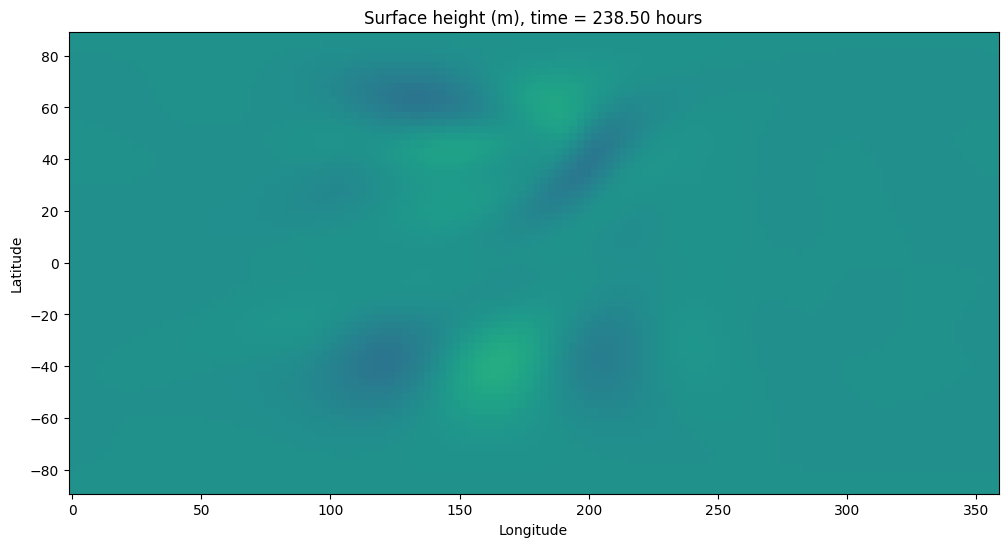

In [83]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(np.pi/2 - theta)*360/2/np.pi, np.squeeze(phi)*360/2/np.pi)

# Define an animation function
def drawframe(n):
    plt.clf()
    height = plt.pcolor(Y, X, h_save[n,:,:], vmin=-0.1, vmax=0.1)
    # Specify the axis limits and labels
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

Estimate the east/west phase speed of these Rossby waves and compare them with the phase speed that you can infer from the simulation by plotting the height,  h , as a function of longitude and time. Discuss the spatial structure of the Rossby waves and any discrepancies that you see between your estimated and measured phase speeds.

Estimate the east/west phase speed of these Rossby waves:
c_g = c_p by shallow water approximation.
so wavespeed = \sqrt(gH) and varies with total ocean depth (including wave height).


198.05226799315417


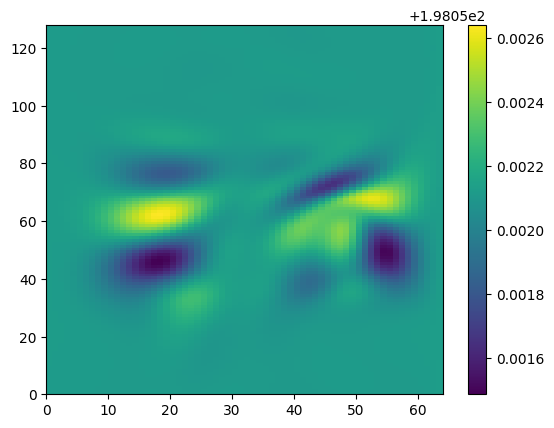

In [169]:
c_g = np.sqrt(g*(H+h_save))
# plt.plot(np.asarray(t_save), c_g[:, 95, 47])
# plt.plot(np.asarray(t_save), c_g[:, 95, 15])
# plt.plot(np.asarray(t_save), c_g[:, 63, 47])
# plt.plot(np.asarray(t_save), c_g[:, 63, 15])
# plt.plot(np.asarray(t_save), c_g[:, 63, 31])
print(c_g[-5, 63, 47])
plt.pcolor(c_g[-10, :, :])
plt.colorbar()


(145, 128, 64)


Text(0.5, 1.0, 'Height as a function of longitude and time at 45 degrees S')

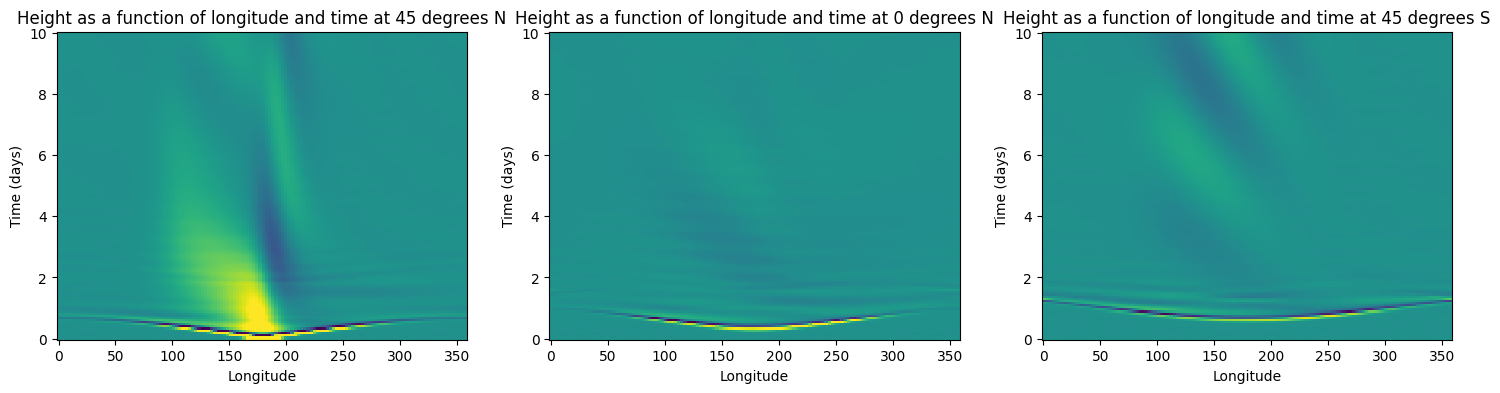

In [92]:
print(h_save.shape) # 1441, 128, 64 # time, lat(Y), lon(X)

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(18, 4))
#note that : # pcolour puts the first dim on the y axis and the second on the x-axis
#https://matplotlib.org/stable/gallery/images_contours_and_fields/pcolor_demo.html#sphx-glr-gallery-images-contours-and-fields-pcolor-demo-py
# note that the solver adds a values to the array for every 10 timesetsp and we used timestep = 600*second
axes[0].pcolor(np.squeeze(phi)*360/2/np.pi, np.arange(0, 10*day + 600, 600*second*10)/day, h_save[:, :, 47], vmin = -0.1, vmax = 0.1)
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Time (days)')
axes[0].set_title('Height as a function of longitude and time at 45 degrees N')

axes[1].pcolor(np.squeeze(phi)*360/2/np.pi, np.arange(0, 10*day + 600, 600*second*10)/day, h_save[:, :, 31], vmin = -0.1, vmax = 0.1)
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Time (days)')
axes[1].set_title('Height as a function of longitude and time at 0 degrees N')

axes[2].pcolor(np.squeeze(phi)*360/2/np.pi, np.arange(0, 10*day + 600, 600*second*10)/day, h_save[:, :, 15], vmin = -0.1, vmax = 0.1)
axes[2].set_xlabel('Longitude')
axes[2].set_ylabel('Time (days)')
axes[2].set_title('Height as a function of longitude and time at 45 degrees S')

Planetary Rossby waves move east to west.

First a very rough etsimate from the animation (to see if our time-longitude plot gives a estimate of similar order): At t=53.5hour there is a peak at 220 degrees longitude and it moves westward, by t=128.5hours its approximately at 145 degrees longitude. Calculating the circumference band at 50 degree latitude by the formula (where R = earth's radius) c = 2 \pi R * cos(50°) = 25730.5km. Divding this by 360 and multiplying by 75  = 5360.5 km. Dividing by 75 hours give group speed as 71.7km/h = 19.85m/s.
Estimating from the plot at 45deg S wher wave are clear pick two peaks (ligther green)  estimate point 1 at t=6*day, lon = 149 and point 2 at t=8.5days, lon = 190. a longitidinal distatnce of 41deg at latitude =   50 deg S is about $\frac{41}{360}2\pi R \cos(-50°) \approx \frac{41}{360}\times25727km = 2930km$. Distance divided by time is $\frac{2930km}{2.5days} = 13.6 m/s$ therfore we have an estimate for group wave speed.

Discuss the spatial structure of the Rossby waves and any discrepancies that you see between your estimated and measured phase speeds.

## 4. Optional further investigations

* In the example of the shallow water equations on a sphere, introduce bathymetry by making $H$ a function of latitude and longitude. Make sure that you modify the equations in Dedalus appropriately. How do the waves behave when they encounter shallow water (e.g. a localized seamount)?

* It is quite difficult to simulate changing sea level (sometimes called wetting and drying), which is why the examples above do not include land. However, we can estimate the distance that a Tsunami will propagate using physical and dimensional arguments. Consider, for example, a flat, sloping beach. In the absence of energy dissipation, estimate the distance that a wave will propagate onshore. How could you modify this estimate to include energy dissipation (or drag)?